# Composer Classification with Deep Learning

## Setup

### Installs

In [ ]:
!sudo apt install -y fluidsynth

In [ ]:
!pip install --upgrade pyfluidsynth

In [ ]:
!pip install pretty_midi mido

In [ ]:
!pip install pypianoroll

### Import modules

In [5]:
import collections
import datetime
import fluidsynth
import glob
import os
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import mido
import pypianoroll
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from IPython import display as ipydisplay
from typing import Optional
from nltk.probability import FreqDist
from itertools import chain
from tensorflow.keras import layers
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

### Download dataset from github

In [6]:
 # Download dataset from github
!wget https://github.com/julietlawton/composer-classification/raw/main/composers.zip

--2024-08-10 17:40:47--  https://github.com/julietlawton/composer-classification/raw/main/composers.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://media.githubusercontent.com/media/julietlawton/composer-classification/main/composers.zip [following]
--2024-08-10 17:40:47--  https://media.githubusercontent.com/media/julietlawton/composer-classification/main/composers.zip
Resolving media.githubusercontent.com (media.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13436472 (13M) [application/zip]
Saving to: ‘composers.zip’

composers.zip       100%[===================>]  12.81M  --.-KB/s    in 0.1s    

2024-08-10 17:40:48 (114 MB/s) - ‘composers.zip’ save

In [ ]:
# Unzip the compressed dataset
!unzip composers.zip

## Feature Extraction

### Load songs

In [78]:
# Set the path to the composers directory
composers_dir = '/content/composers/'

# List the composers that will be used for classification
composers = next(os.walk(composers_dir))[1]

# Create objects to store each song and its composer
songs = []
labels = []

# Get each composer/song pair
for composer in composers:
  root = composers_dir+composer
  for file in os.listdir(root):
    if '.mid' in file:
      path = os.path.join(root, file)
      songs.append(path)
      labels.append(composer)

# Create a dataframe to store all the songs and use with feature extraction
composers_df = pd.DataFrame({'song': songs, 'composer': labels})

In [79]:
# Drop the two songs that can't be processed by pretty midi
broken_songs = ['/content/composers/Beethoven/Anhang 14-3.mid', '/content/composers/Mozart/K281 Piano Sonata n03 3mov.mid']

composers_df = composers_df[~composers_df['song'].isin(broken_songs)]

In [80]:
# Check the first 5 entries
composers_df.head()

song   composer
0  /content/composers/Beethoven/Symphony n2 op36 ...  Beethoven
1  /content/composers/Beethoven/Piano Sonata n06.mid  Beethoven
2  /content/composers/Beethoven/Piano Sonata n29 ...  Beethoven
3  /content/composers/Beethoven/Rondo Opus.51, No...  Beethoven
4  /content/composers/Beethoven/Overture ''Leonor...  Beethoven

Total number of songs: 1529


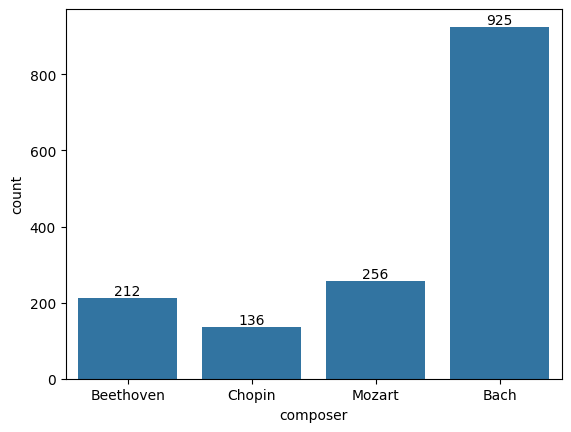

In [81]:
# Print total number of songs
print(f'Total number of songs: {len(composers_df)}')

# Plot the song counts for each composer
ax = sns.countplot(data=composers_df, x='composer')
ax.bar_label(ax.containers[0])
plt.show()

### Downsampling

Total number of songs after downsampling: 1116


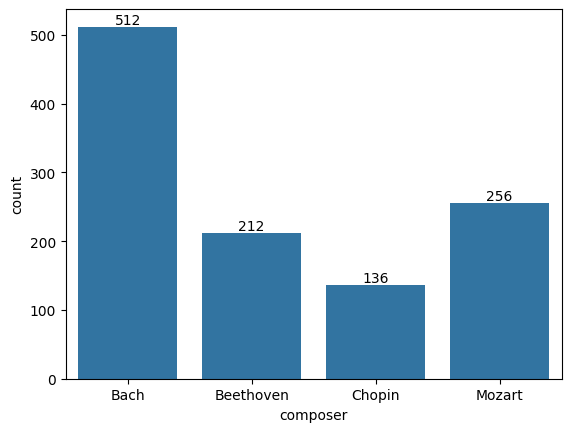

In [82]:
# Downsample Bach songs to address class imbalance
bach_songs = composers_df[composers_df['composer'] == 'Bach']
n_samples = len(composers_df[composers_df['composer'] == 'Mozart'])*2

bach_downsample = resample(
    bach_songs,
    replace=True,
    n_samples=n_samples,
    random_state=42
)

# Add the downsampled Bach songs back to the other songs
non_bach_songs = composers_df[composers_df['composer'] != 'Bach']
composers_df = pd.concat([bach_downsample, non_bach_songs])

# Print total number of songs
print(f'Total number of songs after downsampling: {len(composers_df)}')

# Plot the song counts for each composer
ax = sns.countplot(data=composers_df, x='composer')
ax.bar_label(ax.containers[0])
plt.show()

### Upsampling

Total number of songs after upsampling: 1236


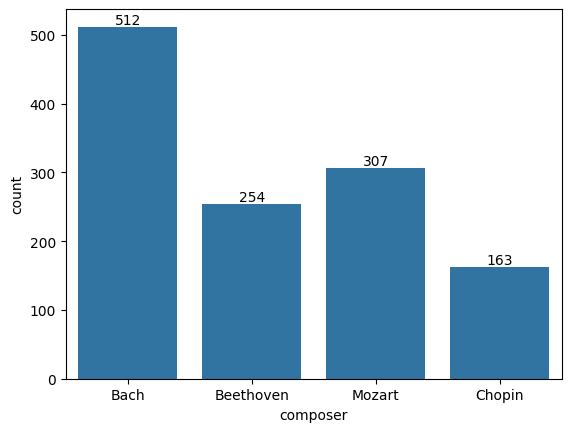

In [83]:
# Upsample non-Bach songs to address class imbalance
beethoven_songs = composers_df[composers_df['composer'] == 'Beethoven']
n_samples = int(len(composers_df[composers_df['composer'] == 'Beethoven'])*1.2)

beethoven_upsample = resample(
    beethoven_songs,
    replace=True,
    n_samples=n_samples,
    random_state=42
)

mozart_songs = composers_df[composers_df['composer'] == 'Mozart']
n_samples = int(len(composers_df[composers_df['composer'] == 'Mozart'])*1.2)

mozart_upsample = resample(
    mozart_songs,
    replace=True,
    n_samples=n_samples,
    random_state=42
)

chopin_songs = composers_df[composers_df['composer'] == 'Chopin']
n_samples = int(len(composers_df[composers_df['composer'] == 'Chopin'])*1.2)

chopin_upsample = resample(
    chopin_songs,
    replace=True,
    n_samples=n_samples,
    random_state=42
)

# Add upsampled songs Back to the bach songs
bach_songs = composers_df[composers_df['composer'] == 'Bach']
composers_df = pd.concat([
    bach_songs,
    beethoven_upsample,
    mozart_upsample,
    chopin_upsample
])

# Print total number of songs
print(f'Total number of songs after upsampling: {len(composers_df)}')

# Plot the song counts for each composer
ax = sns.countplot(data=composers_df, x='composer')
ax.bar_label(ax.containers[0])
plt.show()

### Visualize songs

In [13]:
# Define a method for playing a snippet of a song
# SOURCE: https://www.tensorflow.org/tutorials/audio/music_generation#process_a_midi_file
sampling_rate = 16000
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=sampling_rate)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*sampling_rate]
  return ipydisplay.Audio(waveform_short, rate=sampling_rate)

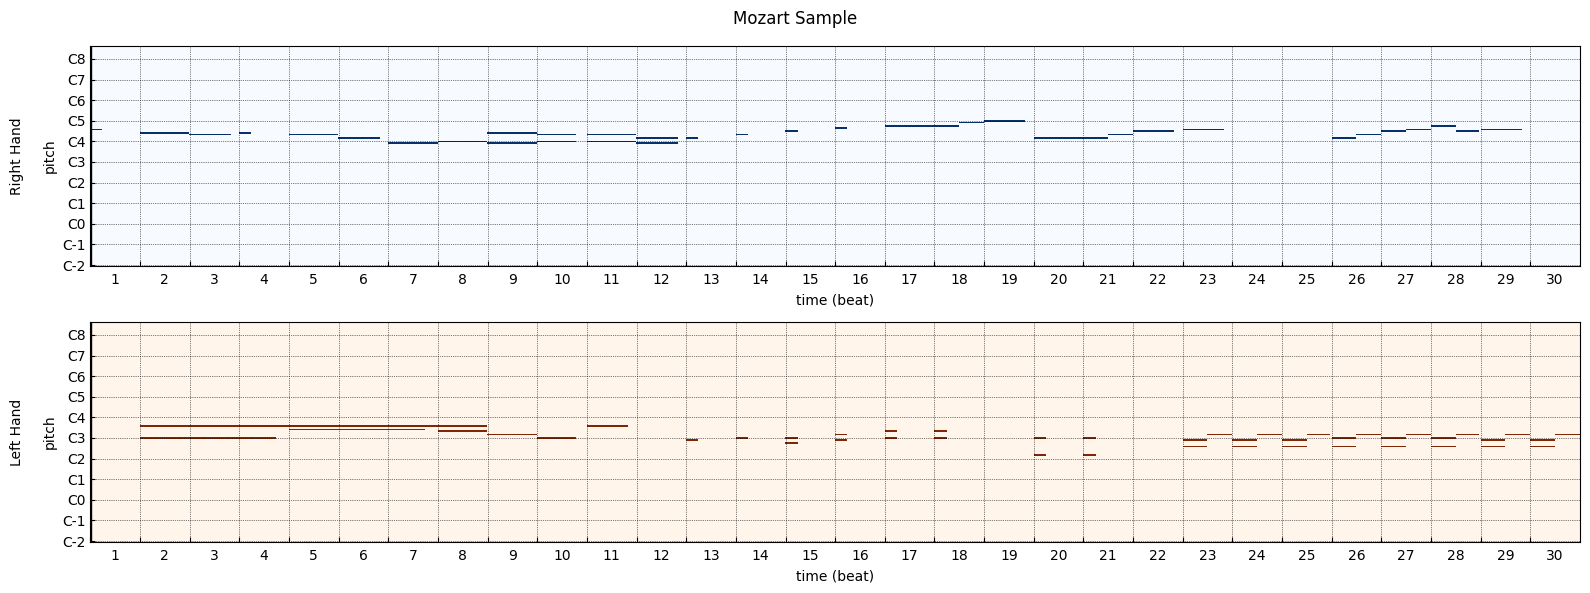

In [16]:
# Load a sample of a song by each composer and plot the piano roll
mozart_sample_file = composers_df['song'][composers_df['composer'] == 'Mozart'].iloc[10]

# Parse the sample file as a piano roll
multitrack = pypianoroll.read(mozart_sample_file)

# Trim the tracks to just the first 30 beats
multitrack.trim(
    start=(0 * multitrack.resolution),
    end=(30 * multitrack.resolution)
)
multitrack.binarize()

# Plot the piano roll for each track
fig, axs = plt.subplots(len(multitrack.tracks), 1, figsize=(16, 6))
multitrack.plot(axs=axs)
fig.suptitle('Mozart Sample')
plt.tight_layout()
plt.show()

# Load the audio snippet
mozart_pm = pretty_midi.PrettyMIDI(mozart_sample_file)
display_audio(mozart_pm)



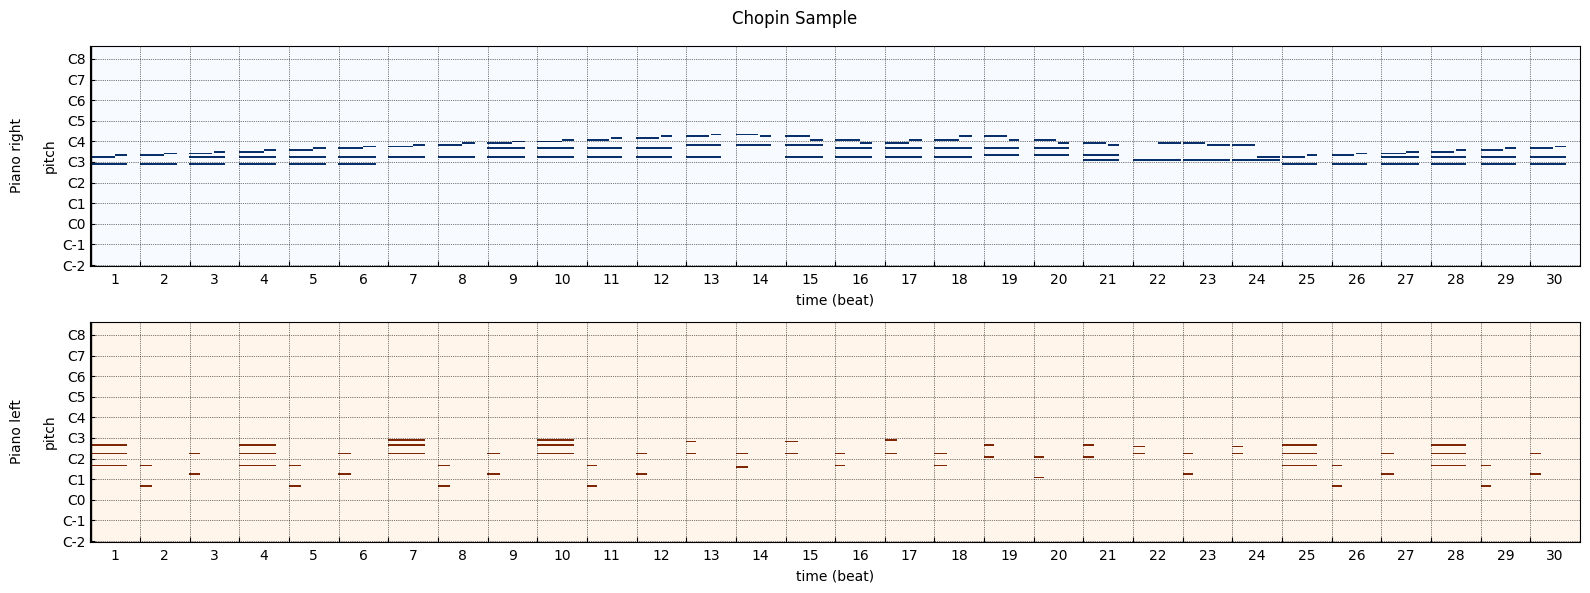

In [17]:
# Load a sample of a song by each composer and plot the piano roll
chopin_sample_file = composers_df['song'][composers_df['composer'] == 'Chopin'].iloc[1]

# Parse the sample file as a piano roll
multitrack = pypianoroll.read(chopin_sample_file)

# Trim the tracks to just the first 30 beats
multitrack.trim(
    start=(0 * multitrack.resolution),
    end=(30 * multitrack.resolution)
)
multitrack.binarize()

# Plot the piano roll for each track
fig, axs = plt.subplots(len(multitrack.tracks), 1, figsize=(16, 6))
multitrack.plot(axs=axs)
fig.suptitle('Chopin Sample')
plt.tight_layout()
plt.show()

# Load the audio snippet
chopin_pm = pretty_midi.PrettyMIDI(chopin_sample_file)
display_audio(chopin_pm)


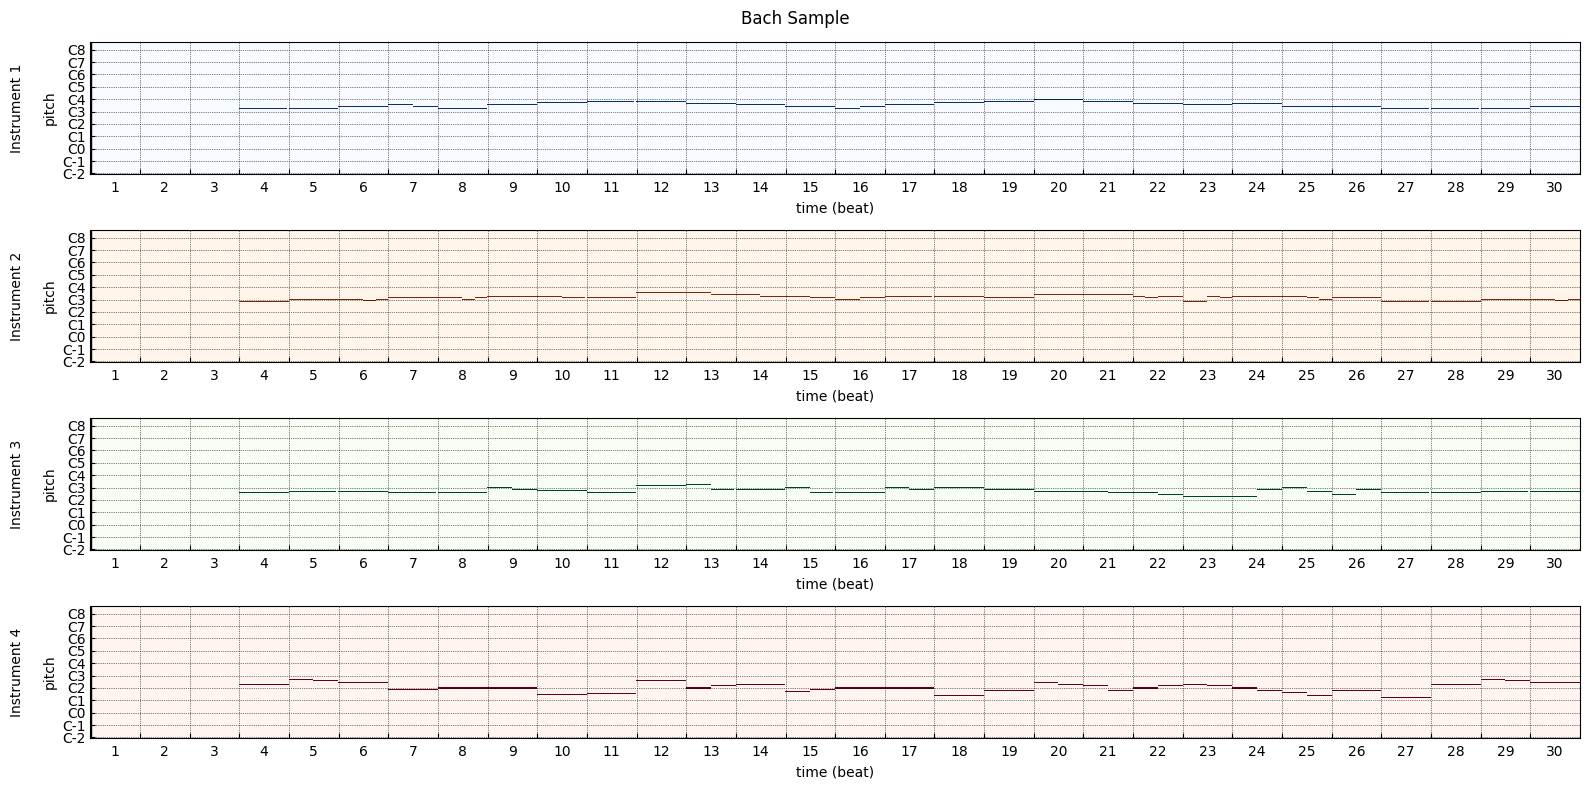

In [18]:
# Load a sample of a song by each composer and plot the piano roll
bach_sample_file = composers_df['song'][composers_df['composer'] == 'Bach'].iloc[1]

# Parse the sample file as a piano roll
multitrack = pypianoroll.read(bach_sample_file)

# Trim the tracks to just the first 30 beats
multitrack.trim(
    start=(0 * multitrack.resolution),
    end=(30 * multitrack.resolution)
)
multitrack.binarize()

# Plot the piano roll for each track
fig, axs = plt.subplots(len(multitrack.tracks), 1, figsize=(16, 8))
multitrack.plot(axs=axs)
fig.suptitle('Bach Sample')
plt.tight_layout()
plt.show()

# Load the audio snippet
bach_pm = pretty_midi.PrettyMIDI(bach_sample_file)
display_audio(bach_pm)

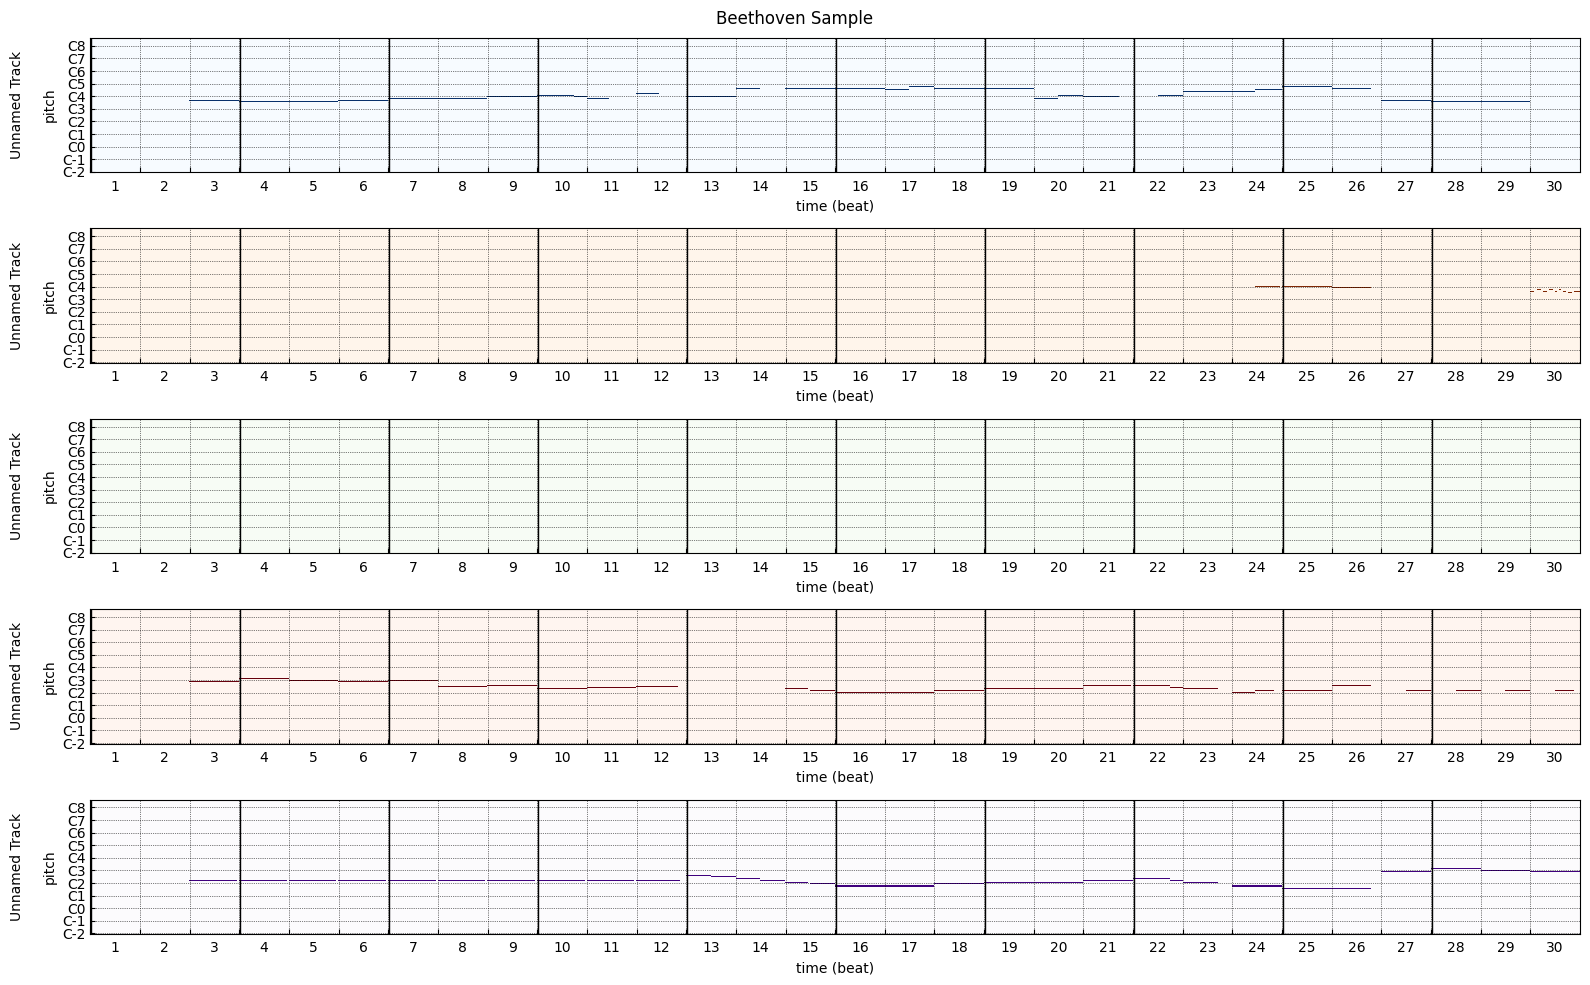

In [26]:
# Load a sample of a song by each composer and plot the piano roll
beethoven_sample_file = composers_df['song'][composers_df['composer'] == 'Beethoven'].iloc[13]

# Parse the sample file as a piano roll
multitrack = pypianoroll.read(beethoven_sample_file)

# Trim the tracks to just the first 30 beats
multitrack.trim(
    start=(0 * multitrack.resolution),
    end=(30 * multitrack.resolution)
)
multitrack.binarize()

# Plot the piano roll for each track
fig, axs = plt.subplots(len(multitrack.tracks), 1, figsize=(16, 10))
multitrack.plot(axs=axs)
fig.suptitle('Beethoven Sample')
plt.tight_layout()
plt.show()

# Load the audio snippet
beethoven_pm = pretty_midi.PrettyMIDI(beethoven_sample_file)
display_audio(beethoven_pm)

### Extract piano rolls

In [43]:
# Set a sample file to test the feature extraction methods with
sample_file = '/content/composers/Chopin/19 Polish Songs, for Solo Voice and Piano accomplements, No.10.mid'

In [44]:
# Define a method for extracting pretty midi piano rolls
def extract_piano_roll(song_file_path, fs=100):
  try:
    pm = pretty_midi.PrettyMIDI(song_file_path)
    piano_roll = pm.get_piano_roll(fs=fs)

    return pd.Series([piano_roll])

  # Handle files that can't be read by pretty midi
  except Exception as e:
    print(f'Error processing {song_file_path} with pretty_midi')
    print(e)

  return pd.Series([np.nan])

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


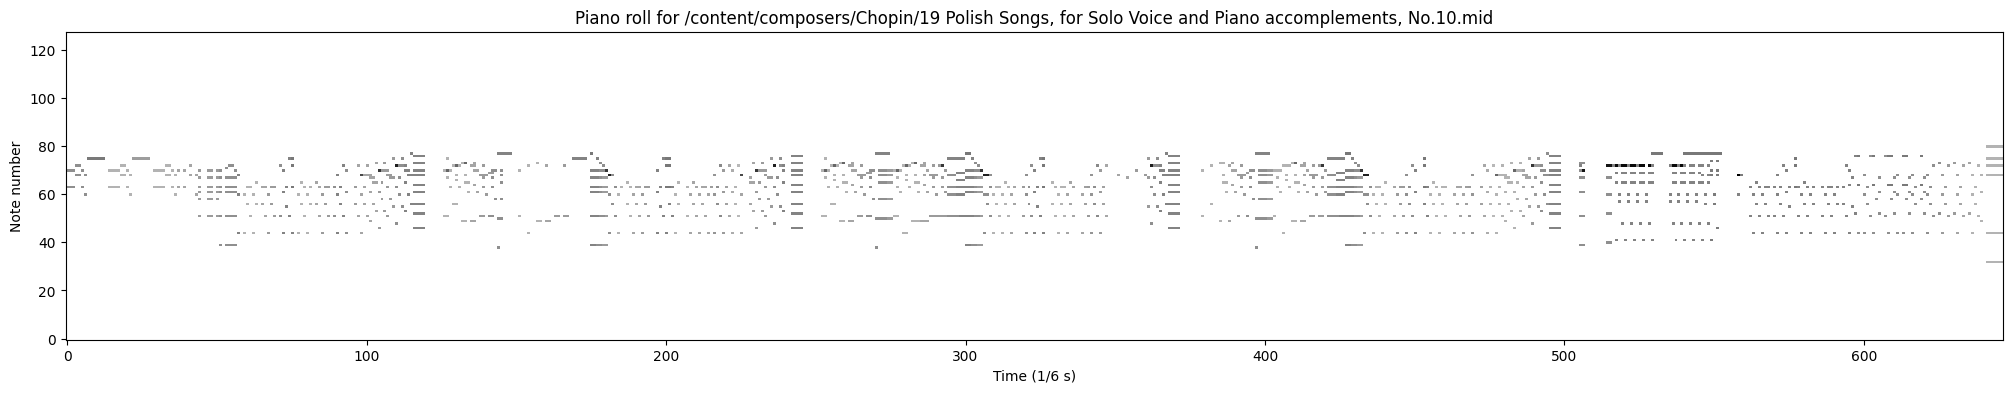

(128, 647)


In [50]:
# Test extract_piano_roll on one song
fs=6
piano_roll = extract_piano_roll(sample_file, fs=fs)

# Plot the piano roll
fig, ax = plt.subplots(figsize=(25, 4))
ax.imshow(
    piano_roll.values[0],
    aspect='auto',
    origin='lower',
    interpolation='nearest',
    cmap='gray_r'
)
plt.xlabel(f'Time (1/{fs} s)')
plt.ylabel('Note number')
plt.title(f'Piano roll for {sample_file}')
plt.show()

print(piano_roll[0].shape)

In [51]:
# Apply to the whole dataframe
composers_df['piano_roll'] = composers_df['song'].apply(lambda song:
                                                        extract_piano_roll(song, fs=6))
composers_df.head()

song composer  \
708   /content/composers/Bach/035400b_.mid     Bach   
1041  /content/composers/Bach/040200b_.mid     Bach   
1466  /content/composers/Bach/014500ba.mid     Bach   
876   /content/composers/Bach/Bwv010.7.mid     Bach   
712   /content/composers/Bach/010207b_.mid     Bach   

                                             piano_roll  
708   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1041  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1466  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
876   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
712   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [52]:
# Drop any songs that could not be parsed by pretty midi
composers_df.dropna(inplace=True)

### Extract instrument info

In [53]:
# Define method for using pretty midi to extract granular instrument info
def extract_instrument_info(song_file_path):
  try:
    # Instantiate a pretty midi object
    pm = pretty_midi.PrettyMIDI(song_file_path)
    instrument_ids = []
    instrument_classes = []
    num_instruments = len(pm.instruments)

    # For every instrument in the song, extract the class, id (program number), and name
    for instrument in pm.instruments:
      instrument_class = pretty_midi.program_to_instrument_class(instrument.program)
      instrument_ids.append(instrument.program)
      instrument_classes.append(instrument_class)

    return pd.Series([num_instruments, instrument_ids, instrument_classes])

  # Handle files that can't be read by pretty midi
  except Exception as e:
    print(f'Error processing {song_file_path} with pretty_midi')
    print(e)

  return pd.Series([np.nan, np.nan, np.nan])

In [54]:
# Test method on one song
extract_instrument_info(sample_file)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


0                    2
1              [0, 53]
2    [Piano, Ensemble]
dtype: object

In [55]:
# Apply instrument extraction method to the dataframe
composers_df[[
    'num_instruments',
    'instrument_ids',
    'instrument_classes'
]] = composers_df['song'].apply(extract_instrument_info)

composers_df.head()

song composer  \
708   /content/composers/Bach/035400b_.mid     Bach   
1041  /content/composers/Bach/040200b_.mid     Bach   
1466  /content/composers/Bach/014500ba.mid     Bach   
876   /content/composers/Bach/Bwv010.7.mid     Bach   
712   /content/composers/Bach/010207b_.mid     Bach   

                                             piano_roll  num_instruments  \
708   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1041  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1466  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
876   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
712   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   

     instrument_ids            instrument_classes  
708    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]  
1041   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]  
1466   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]  
876    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]  
712    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]

In [56]:
# View overall distribution of num_instruments
composers_df['num_instruments'].describe()

count    1236.000000
mean        5.420712
std         4.813883
min         1.000000
25%         2.000000
50%         4.000000
75%         6.000000
max        40.000000
Name: num_instruments, dtype: float64

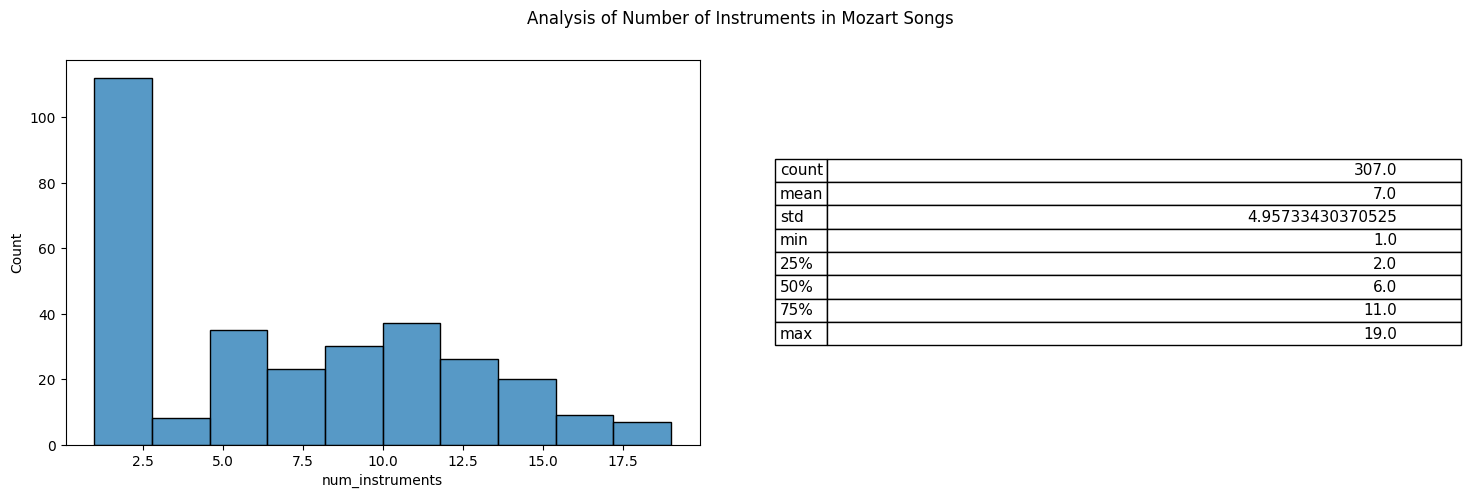

In [57]:
# Analyze the number of instruments in Mozart songs
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot the distribution of number of instruments
sns.histplot(
    data=composers_df[composers_df['composer'] == 'Mozart'],
    x='num_instruments',
    ax=axs[0]
)

# Create a table showing the descriptive statistics for this variable
stats = composers_df['num_instruments'][composers_df['composer'] == 'Mozart'].describe().to_frame()
stats_table = axs[1].table(
    cellText=stats.values,
    rowLabels=stats.index,
    loc='center'
)
stats_table.set_fontsize(11)
stats_table.scale(1, 1.4)
axs[1].axis('off')
fig.suptitle('Analysis of Number of Instruments in Mozart Songs')
plt.show()

In [58]:
# Get a list of all instruments used in each song
instruments_used = np.hstack(
    composers_df['instrument_classes'][composers_df['composer'] == 'Mozart']
    .values
).tolist()

# Find the frequency of each class of instrument
fdist = FreqDist(instruments_used)
fdist

FreqDist({'Ensemble': 735, 'Piano': 477, 'Reed': 325, 'Brass': 267, 'Strings': 193, 'Pipe': 104, 'Organ': 44, 'Synth Lead': 4})

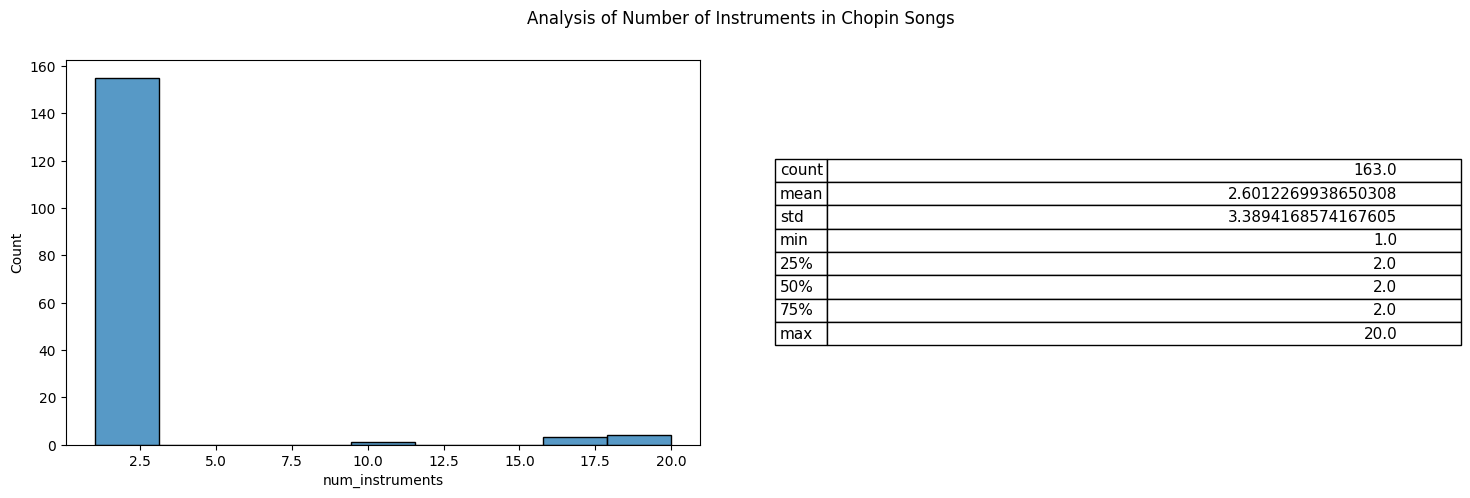

In [59]:
# Analyze the number of instruments in Chopin songs
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot the distribution of number of instruments
sns.histplot(
    data=composers_df[composers_df['composer'] == 'Chopin'],
    x='num_instruments',
    ax=axs[0]
)

# Create a table showing the descriptive statistics for this variable
stats = composers_df['num_instruments'][composers_df['composer'] == 'Chopin'].describe().to_frame()
stats_table = axs[1].table(
    cellText=stats.values,
    rowLabels=stats.index,
    loc='center'
)
stats_table.set_fontsize(11)
stats_table.scale(1, 1.4)
axs[1].axis('off')
fig.suptitle('Analysis of Number of Instruments in Chopin Songs')
plt.show()

In [60]:
# Get a list of all instruments used in each song
instruments_used = np.hstack(
    composers_df['instrument_classes'][composers_df['composer'] == 'Chopin']
    .values
).tolist()

# Find the frequency of each class of instrument
fdist = FreqDist(instruments_used)
fdist

FreqDist({'Piano': 277, 'Ensemble': 56, 'Strings': 34, 'Brass': 24, 'Reed': 23, 'Pipe': 8, 'Sound Effects': 2})

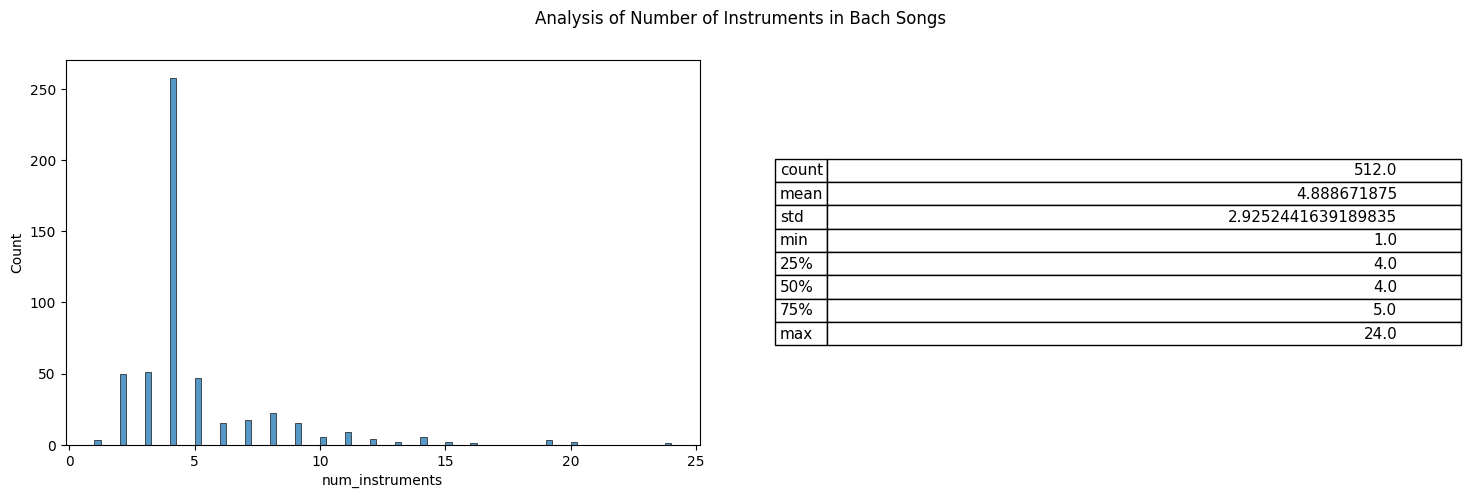

In [61]:
# Analyze the number of instruments in Bach songs
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot the distribution of number of instruments
sns.histplot(
    data=composers_df[composers_df['composer'] == 'Bach'],
    x='num_instruments',
    ax=axs[0]
)

# Create a table showing the descriptive statistics for this variable
stats = composers_df['num_instruments'][composers_df['composer'] == 'Bach'].describe().to_frame()
stats_table = axs[1].table(
    cellText=stats.values,
    rowLabels=stats.index,
    loc='center'
)
stats_table.set_fontsize(11)
stats_table.scale(1, 1.4)
axs[1].axis('off')
fig.suptitle('Analysis of Number of Instruments in Bach Songs')
plt.show()

In [62]:
# Get a list of all instruments used in each song
instruments_used = np.hstack(
    composers_df['instrument_classes'][composers_df['composer'] == 'Bach']
    .values
).tolist()

# Find the frequency of each class of instrument
fdist = FreqDist(instruments_used)
fdist

FreqDist({'Piano': 1699, 'Ensemble': 250, 'Strings': 248, 'Reed': 138, 'Brass': 51, 'Organ': 49, 'Pipe': 41, 'Guitar': 11, 'Chromatic Percussion': 8, 'Bass': 4, ...})

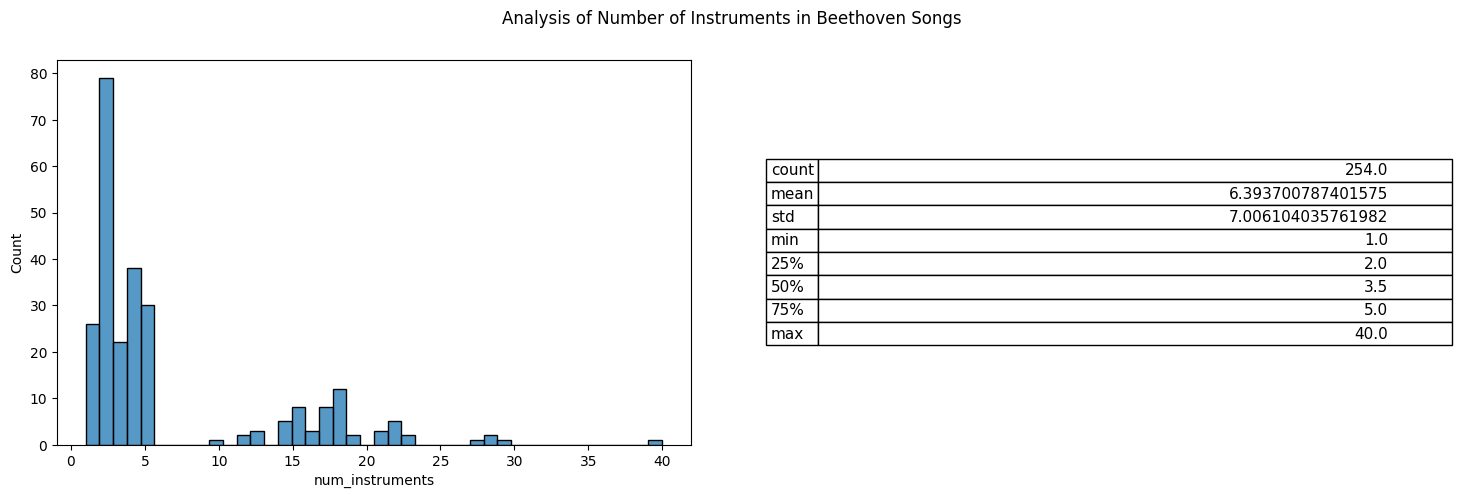

In [63]:
# Analyze the number of instruments in Beethoven songs
fig, axs = plt.subplots(1, 2, figsize=(18, 5))

# Plot the distribution of number of instruments
sns.histplot(
    data=composers_df[composers_df['composer'] == 'Beethoven'],
    x='num_instruments',
    ax=axs[0]
)

# Create a table showing the descriptive statistics for this variable
stats = composers_df['num_instruments'][composers_df['composer'] == 'Beethoven'].describe().to_frame()
stats_table = axs[1].table(
    cellText=stats.values,
    rowLabels=stats.index,
    loc='center'
)
stats_table.set_fontsize(11)
stats_table.scale(1, 1.4)
axs[1].axis('off')
fig.suptitle('Analysis of Number of Instruments in Beethoven Songs')
plt.show()

In [64]:
# Get a list of all instruments used in each song
instruments_used = np.hstack(
    composers_df['instrument_classes'][composers_df['composer'] == 'Beethoven']
    .values
).tolist()

# Find the frequency of each class of instrument
fdist = FreqDist(instruments_used)
fdist

FreqDist({'Piano': 569, 'Ensemble': 338, 'Strings': 273, 'Reed': 194, 'Brass': 177, 'Pipe': 71, 'Bass': 2})

### Extract note sequences

In [65]:
# Define method for extracting notes from the songs
def extract_note_sequences(song_file_path):
  try:
    pm = pretty_midi.PrettyMIDI(song_file_path)
    note_sequence = []
    note_name_sequences = []

    # For each track, store the notes (pitch velocity duration)
    # as well as the track id and instrument id
    for track_id, track in enumerate(pm.instruments):
      instrument_id = track.program
      note_names = []

      for note in track.notes:
        note_name = pretty_midi.note_number_to_name(note.pitch)
        note_names.append(note_name)
        pitch = note.pitch
        velocity = note.velocity
        duration = note.end - note.start
        note_sequence.append([pitch, velocity, duration, track_id, instrument_id])

      note_name_sequences.append(note_names)

    return pd.Series([np.array(note_sequence), note_name_sequences])

  # Handle files that can't be read by pretty midi
  except Exception as e:
    print(f'Error processing {song_file_path} with pretty midi')
    print(e)

  return pd.Series([np.nan, np.nan])

In [66]:
# Test on one sample file
extract_note_sequences(sample_file)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


0    [[70.0, 105.0, 0.24990780000000004, 0.0, 0.0],...
1    [[A#4, D#4, A#4, D#4, A#4, D#4, C5, G#4, A#4, ...
dtype: object

In [67]:
# Apply instrument extraction method to the dataframe
composers_df[[
    'note_sequences',
    'note_name_sequences'
]] = composers_df['song'].apply(extract_note_sequences)

composers_df.head()

song composer  \
708   /content/composers/Bach/035400b_.mid     Bach   
1041  /content/composers/Bach/040200b_.mid     Bach   
1466  /content/composers/Bach/014500ba.mid     Bach   
876   /content/composers/Bach/Bwv010.7.mid     Bach   
712   /content/composers/Bach/010207b_.mid     Bach   

                                             piano_roll  num_instruments  \
708   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1041  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1466  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
876   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
712   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   

     instrument_ids            instrument_classes  \
708    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
1041   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
1466   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
876    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
712    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   

                                         note_sequences  \
708   [[77.0, 96.0, 0.666666, 0.0, 0.0], [77.0, 96.0...   
1041  [[63.0, 96.0, 0.625, 0.0, 0.0], [63.0, 96.0, 0...   
1466  [[69.0, 96.0, 0.625, 0.0, 0.0], [67.0, 96.0, 0...   
876   [[74.0, 96.0, 1.276594, 0.0, 0.0], [77.0, 96.0...   
712   [[67.0, 96.0, 0.5769230000000001, 0.0, 0.0], [...   

                                    note_name_sequences  
708   [[F5, F5, C5, C#5, D#5, C#5, C5, C5, A#4, C#5,...  
1041  [[D#4, D#4, F4, G4, F4, D#4, G4, A4, A#4, A#4,...  
1466  [[A4, G4, F#4, B4, C#5, D5, D5, C#5, B4, C#5, ...  
876   [[D5, F5, D5, D5, D5, D5, D#5, D5, C5, C5, A#4...  
712   [[G4, G4, D#4, F4, G4, F4, D#4, D4, C4, G4, G4...

In [68]:
# View most commonly used notes for mozart
all_notes = composers_df['note_name_sequences'][composers_df['composer'] == 'Mozart'].values
all_notes_flattened = list(
    chain.from_iterable(
        chain.from_iterable(all_notes)
))

fdist = FreqDist(all_notes_flattened)
fdist

FreqDist({'D4': 86724, 'D5': 74504, 'G4': 70477, 'A4': 69282, 'A3': 62369, 'C4': 62308, 'E4': 57298, 'C5': 57188, 'F4': 56201, 'G3': 54674, ...})

In [69]:
# View most commonly used notes for chopin
all_notes = composers_df['note_name_sequences'][composers_df['composer'] == 'Chopin'].values
all_notes_flattened = list(
    chain.from_iterable(
        chain.from_iterable(all_notes)
))

fdist = FreqDist(all_notes_flattened)
fdist

FreqDist({'G#4': 12657, 'C4': 12440, 'C5': 12430, 'F4': 11845, 'D#4': 11102, 'G4': 11033, 'G#3': 10977, 'E4': 10876, 'A#4': 10279, 'D#5': 9785, ...})

In [70]:
# View most commonly used notes for bach
all_notes = composers_df['note_name_sequences'][composers_df['composer'] == 'Bach'].values
all_notes_flattened = list(
    chain.from_iterable(
        chain.from_iterable(all_notes)
))

fdist = FreqDist(all_notes_flattened)
fdist

FreqDist({'A4': 45952, 'D5': 45061, 'G4': 38161, 'B4': 37369, 'D4': 34638, 'E5': 34473, 'C5': 31179, 'E4': 30429, 'A3': 27067, 'D3': 26131, ...})

In [71]:
# View most commonly used notes for beethoven
all_notes = composers_df['note_name_sequences'][composers_df['composer'] == 'Beethoven'].values
all_notes_flattened = list(
    chain.from_iterable(
        chain.from_iterable(all_notes)
))

fdist = FreqDist(all_notes_flattened)
fdist

FreqDist({'C4': 82510, 'D4': 80829, 'G4': 76660, 'G3': 71991, 'C5': 68290, 'F4': 66129, 'D5': 65099, 'A4': 61094, 'A3': 60919, 'E4': 56911, ...})

### Extract song statistics

In [72]:
# Define method for extracting descriptive statistics from the songs
def extract_song_statistics(song_file_path):
  try:
    # Instantiate a pretty midi object
    pm = pretty_midi.PrettyMIDI(song_file_path)

    song_duration = pm.get_end_time()
    total_notes = 0
    note_ids = []
    instrument_ids = []
    velocities = []
    durations = []

    # Get all of the notes
    for track in pm.instruments:
      instrument_ids.append(track.program)

      for note in track.notes:
          total_notes += 1
          note_ids.append(note.pitch)
          velocities.append(note.velocity)
          durations.append(note.end - note.start)

    # Compute statistics using set of notes for the full song
    most_frequent_note = max(set(note_ids), key = note_ids.count)
    most_frequent_instrument = max(set(instrument_ids), key = instrument_ids.count)

    min_note = np.min(note_ids)
    max_note = np.max(note_ids)

    mean_velocity = np.mean(velocities)
    min_velocity = np.min(velocities)
    max_velocity = np.max(velocities)

    mean_duration = np.mean(durations)
    min_duration = np.min(durations)
    max_duration = np.max(durations)

    return pd.Series([
        song_duration,
        total_notes,
        most_frequent_note,
        most_frequent_instrument,
        min_note,
        max_note,
        mean_velocity,
        min_velocity,
        max_velocity,
        mean_duration,
        min_duration,
        max_duration
    ])

  # Handle files that can't be read by pretty midi
  except Exception as e:
    print(f'Error processing {song_file_path} with pretty midi')
    print(e)

  return pd.Series([np.nan] * 12)

In [73]:
# Test on one sample file
extract_song_statistics(sample_file)

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


0      107.915869
1     1742.000000
2       63.000000
3        0.000000
4       32.000000
5       80.000000
6       97.889782
7       66.000000
8      127.000000
9        0.158194
10       0.020826
11       2.166740
dtype: float64

In [74]:
# Apply song statistics method to the dataframe
composers_df[[
    'song_duration',
    'total_notes',
    'most_frequent_note',
    'most_frequent_instrument',
    'min_note',
    'max_note',
    'mean_velocity',
    'min_velocity',
    'max_velocity',
    'mean_duration',
    'min_duration',
    'max_duration'
]] = composers_df['song'].apply(extract_song_statistics)

composers_df.head()

song composer  \
708   /content/composers/Bach/035400b_.mid     Bach   
1041  /content/composers/Bach/040200b_.mid     Bach   
1466  /content/composers/Bach/014500ba.mid     Bach   
876   /content/composers/Bach/Bwv010.7.mid     Bach   
712   /content/composers/Bach/010207b_.mid     Bach   

                                             piano_roll  num_instruments  \
708   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1041  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
1466  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
876   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   
712   [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...                4   

     instrument_ids            instrument_classes  \
708    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
1041   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
1466   [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
876    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   
712    [0, 0, 0, 0]  [Piano, Piano, Piano, Piano]   

                                         note_sequences  \
708   [[77.0, 96.0, 0.666666, 0.0, 0.0], [77.0, 96.0...   
1041  [[63.0, 96.0, 0.625, 0.0, 0.0], [63.0, 96.0, 0...   
1466  [[69.0, 96.0, 0.625, 0.0, 0.0], [67.0, 96.0, 0...   
876   [[74.0, 96.0, 1.276594, 0.0, 0.0], [77.0, 96.0...   
712   [[67.0, 96.0, 0.5769230000000001, 0.0, 0.0], [...   

                                    note_name_sequences  song_duration  \
708   [[F5, F5, C5, C#5, D#5, C#5, C5, C5, A#4, C#5,...      42.666624   
1041  [[D#4, D#4, F4, G4, F4, D#4, G4, A4, A#4, A#4,...      62.500000   
1466  [[A4, G4, F#4, B4, C#5, D5, D5, C#5, B4, C#5, ...      30.000000   
876   [[D5, F5, D5, D5, D5, D5, D#5, D5, C5, C5, A#4...      56.170136   
712   [[G4, G4, D#4, F4, G4, F4, D#4, D4, C4, G4, G4...      29.999996   

      total_notes  most_frequent_note  most_frequent_instrument  min_note  \
708         318.0                65.0                       0.0      44.0   
1041        458.0                63.0                       0.0      39.0   
1466        213.0                57.0                       0.0      43.0   
876         205.0                60.0                       0.0      43.0   
712         228.0                60.0                       0.0      43.0   

      max_note  mean_velocity  min_velocity  max_velocity  mean_duration  \
708       78.0           96.0          96.0          96.0       0.536687   
1041      75.0           96.0          96.0          96.0       0.529476   
1466      78.0           96.0          96.0          96.0       0.563380   
876       77.0           96.0          96.0          96.0       1.077321   
712       75.0           96.0          96.0          96.0       0.495951   

      min_duration  max_duration  
708       0.333333      1.333332  
1041      0.156250      1.250000  
1466      0.156250      1.250000  
876       0.638297      7.659564  
712       0.288461      1.153846

count    1236.000000
mean      296.976844
std       328.642515
min        17.500000
25%        64.568339
50%       204.728405
75%       410.380066
max      5032.305478
Name: song_duration, dtype: float64


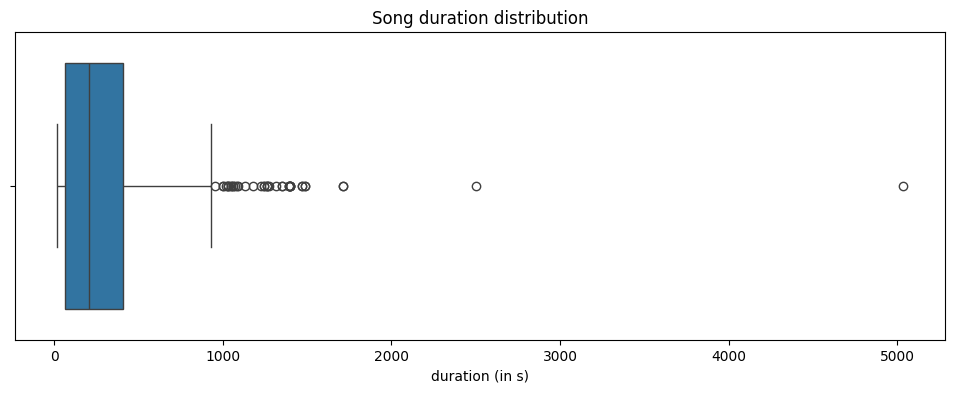

In [75]:
# Print descriptive statistics for song durations
print(composers_df['song_duration'].describe())

# Plot overall distribution of song durations
fig, ax = plt.subplots(figsize=(12, 4))
sns.boxplot(data=composers_df, x='song_duration')
ax.set_title('Song duration distribution')
ax.set_xlabel('duration (in s)')
plt.show()

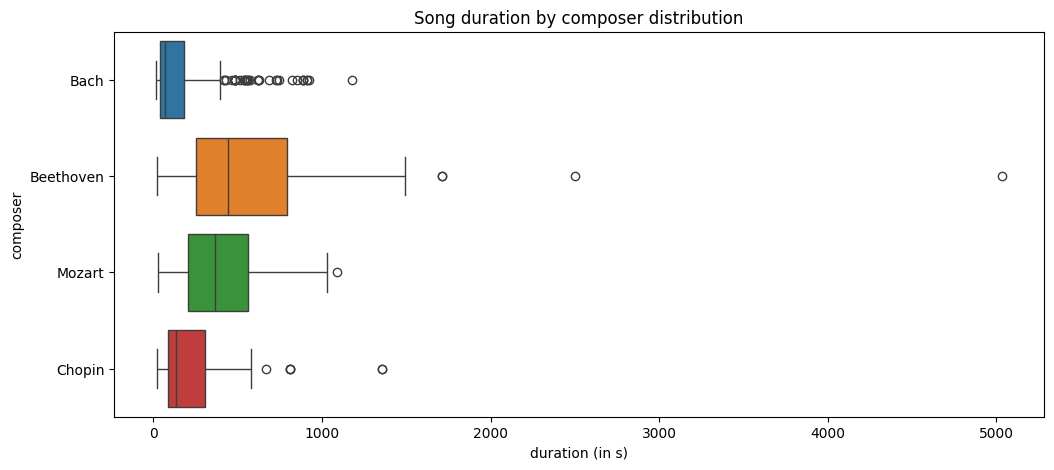

In [76]:
# Plot the distribution of song durations by composer
fig, ax = plt.subplots(figsize=(12, 5))
sns.boxplot(
    data=composers_df,
    x='song_duration',
    y='composer',
    hue='composer',
    ax=ax
)
ax.set_title('Song duration by composer distribution')
ax.set_xlabel('duration (in s)')
plt.show()

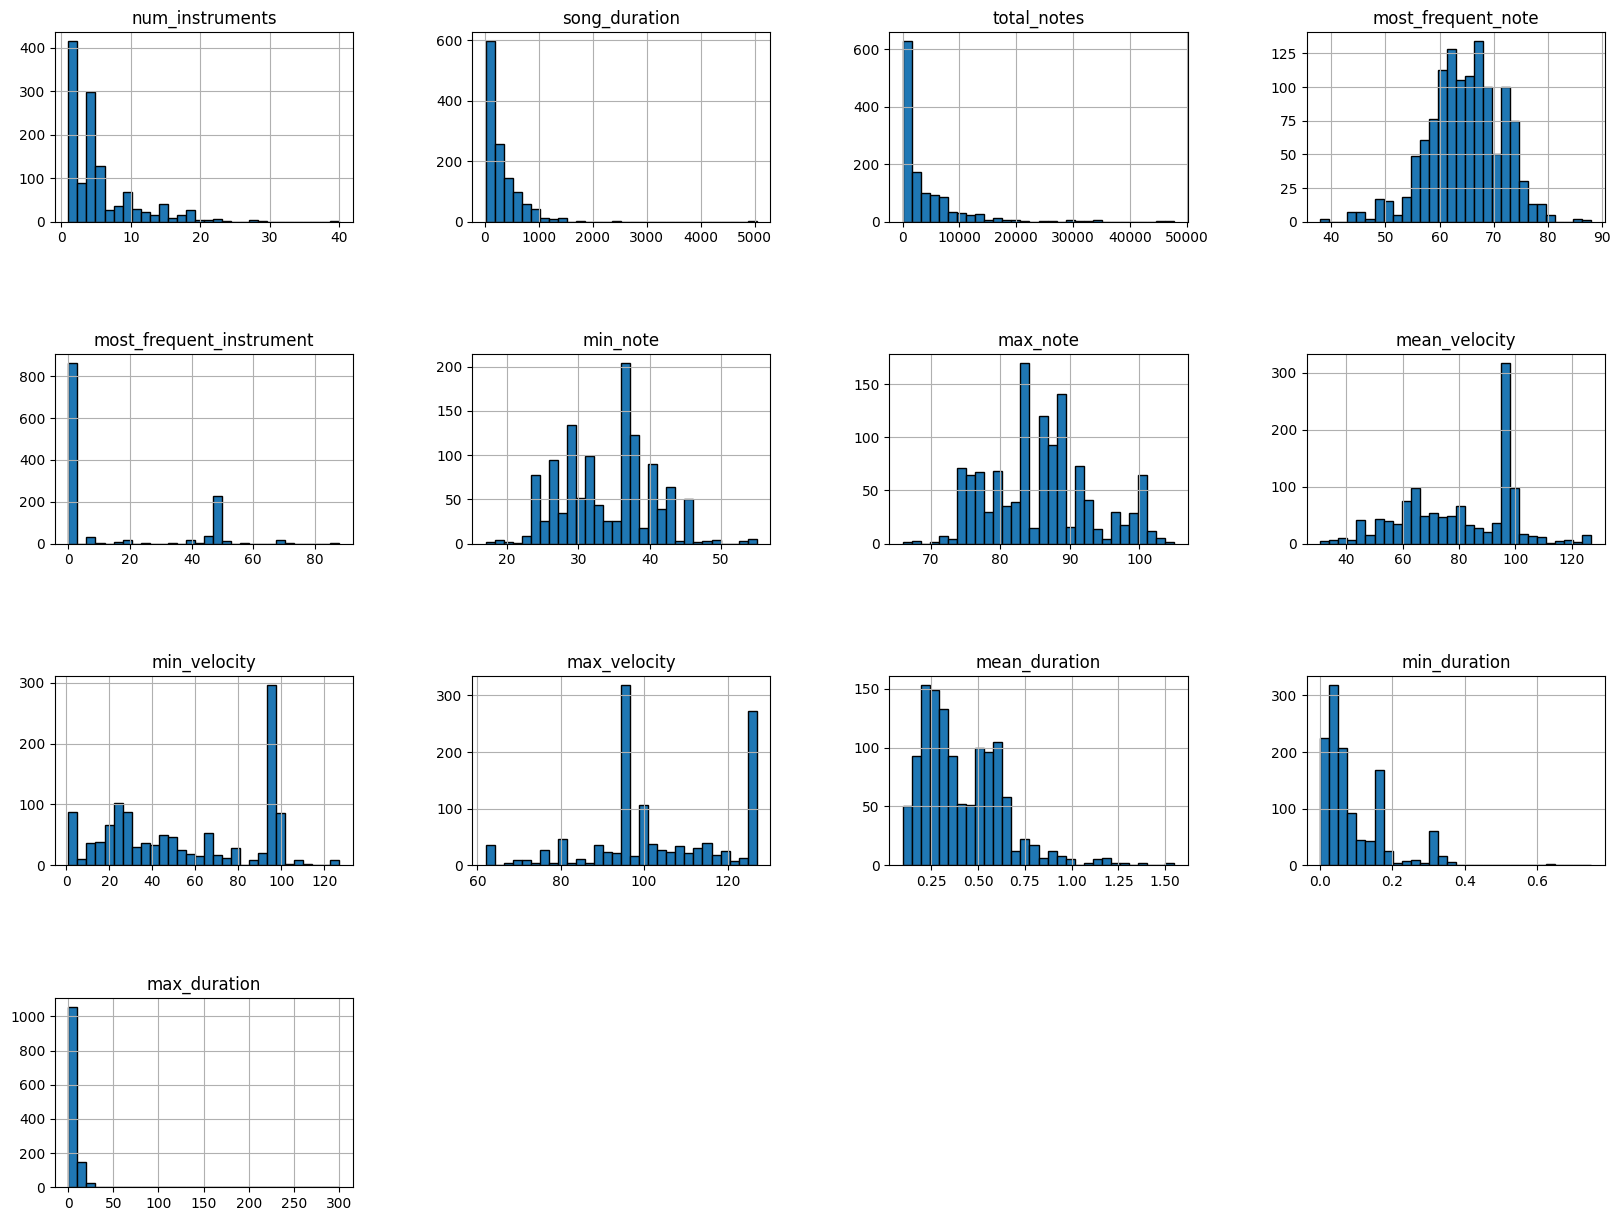

In [77]:
# Examine the distribution of each of the variables
composers_df[[
    'num_instruments',
    'song_duration',
    'total_notes',
    'most_frequent_note',
    'most_frequent_instrument',
    'min_note',
    'max_note',
    'mean_velocity',
    'min_velocity',
    'max_velocity',
    'mean_duration',
    'min_duration',
    'max_duration',
  ]].hist(figsize=(20, 15), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

### Extract all features

In [84]:
# Set a sample file to test the feature extraction methods with
sample_file = '/content/composers/Chopin/19 Polish Songs, for Solo Voice and Piano accomplements, No.10.mid'

In [85]:
# Define a method that extracts all of the above features at once
# use_piano_rolls determines whether to extract piano rolls or
# note sequences
def extract_all_features(song_file_path, use_piano_rolls, fs=100):
  try:
    # Instantiate a pretty midi object
    pm = pretty_midi.PrettyMIDI(song_file_path)

    instrument_ids = []
    num_instruments = len(pm.instruments)

    song_duration = pm.get_end_time()
    total_notes = 0
    note_ids = []
    velocities = []
    durations = []

    # For every instrument in the song, extract the id (program number) and
    # extract all the notes
    for instrument in pm.instruments:
      instrument_ids.append(instrument.program)

      for note in instrument.notes:
          total_notes += 1
          note_ids.append(note.pitch)
          velocities.append(note.velocity)
          durations.append(note.end - note.start)

    # Compute song statistics
    most_frequent_note = max(set(note_ids), key = note_ids.count)
    most_frequent_instrument = max(set(instrument_ids), key = instrument_ids.count)

    min_note = np.min(note_ids)
    max_note = np.max(note_ids)

    mean_velocity = np.mean(velocities)
    min_velocity = np.min(velocities)
    max_velocity = np.max(velocities)

    mean_duration = np.mean(durations)
    min_duration = np.min(durations)
    max_duration = np.max(durations)

    # If using piano rolls, get the piano roll for the song
    if use_piano_rolls:
      piano_roll = pm.get_piano_roll(fs=fs)

      return pd.Series([
          num_instruments,
          song_duration,
          total_notes,
          most_frequent_note,
          most_frequent_instrument,
          min_note,
          max_note,
          mean_velocity,
          min_velocity,
          max_velocity,
          mean_duration,
          min_duration,
          max_duration,
          piano_roll
      ])

    # Else, include the note sequences
    else:
      note_sequence = []

      # For each track, store the notes (pitch velocity duration)
      # as well as their instrument and track id
      for track_id, track in enumerate(pm.instruments):
        instrument_id = track.program

        for note in track.notes:
          pitch = note.pitch
          velocity = note.velocity
          duration = note.end - note.start
          note_sequence.append([pitch, velocity, duration, track_id, instrument_id])

      return pd.Series([
          num_instruments,
          song_duration,
          total_notes,
          most_frequent_note,
          most_frequent_instrument,
          min_note,
          max_note,
          mean_velocity,
          min_velocity,
          max_velocity,
          mean_duration,
          min_duration,
          max_duration,
          np.array(note_sequence)
      ])

  # Handle files that can't be read by pretty midi
  except Exception as e:
    print(f'Error processing {song_file_path} with pretty_midi')
    print(e)

  return pd.Series([np.nan] * 14)

In [86]:
# Test feature extraction on one song
sample_features = extract_all_features(sample_file, use_piano_rolls=True, fs=1)
sample_features

/usr/local/lib/python3.10/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


0                                                     2
1                                            107.915869
2                                                  1742
3                                                    63
4                                                     0
5                                                    32
6                                                    80
7                                             97.889782
8                                                    66
9                                                   127
10                                             0.158194
11                                             0.020826
12                                              2.16674
13    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
dtype: object

In [87]:
# Specifiy whether to extract either piano rolls or note sequences
use_piano_rolls = True

if use_piano_rolls:
  # Apply to whole dataframe (using piano rolls)
  composers_df[[
        'num_instruments',
        'song_duration',
        'total_notes',
        'most_frequent_note',
        'most_frequent_instrument',
        'min_note',
        'max_note',
        'mean_velocity',
        'min_velocity',
        'max_velocity',
        'mean_duration',
        'min_duration',
        'max_duration',
        'piano_roll'
  ]] = composers_df['song'].apply(lambda song: extract_all_features(
                                                song, use_piano_rolls=True, fs=5))
else:
  # Apply to whole dataframe (using note_sequences)
  composers_df[[
        'num_instruments',
        'song_duration',
        'total_notes',
        'most_frequent_note',
        'most_frequent_instrument',
        'min_note',
        'max_note',
        'mean_velocity',
        'min_velocity',
        'max_velocity',
        'mean_duration',
        'min_duration',
        'max_duration',
        'note_sequence'
  ]] = composers_df['song'].apply(lambda song: extract_all_features(
                                                song, use_piano_rolls=False))

In [88]:
# Drop the songs that were not processed correctly
composers_df.dropna(inplace=True)

In [89]:
# View columns after feature extraction
composers_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1236 entries, 708 to 342
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   song                      1236 non-null   object 
 1   composer                  1236 non-null   object 
 2   num_instruments           1236 non-null   int64  
 3   song_duration             1236 non-null   float64
 4   total_notes               1236 non-null   int64  
 5   most_frequent_note        1236 non-null   int64  
 6   most_frequent_instrument  1236 non-null   int32  
 7   min_note                  1236 non-null   int64  
 8   max_note                  1236 non-null   int64  
 9   mean_velocity             1236 non-null   float64
 10  min_velocity              1236 non-null   int64  
 11  max_velocity              1236 non-null   int64  
 12  mean_duration             1236 non-null   float64
 13  min_duration              1236 non-null   float64
 14  max_duration

## Data Preprocessing

### Encode target labels

In [90]:
# Encode the class labels as integers
label_encoder = preprocessing.LabelEncoder()
composers_df['composer_encoded'] = label_encoder.fit_transform(composers_df['composer'])

composers_df['composer_encoded'].unique()

array([0, 1, 3, 2])

### Preprocess piano rolls

In [91]:
# Define a method that pads or truncates piano rolls to be the same length
def pad_piano_roll(piano_roll, seq_length):
  # Define a new piano roll with the shape (128, seq_length)
  padded_piano_roll = np.zeros((piano_roll.shape[0], seq_length), dtype=np.float32)

  # If the piano roll is shorter than the sequence length, add padding
  if piano_roll.shape[1] < seq_length:
    padded_piano_roll[:, :piano_roll.shape[1]] = piano_roll[:, :]

  # If the piano roll is too long, truncate it
  elif piano_roll.shape[1] > seq_length:
    padded_piano_roll[:, :seq_length] = piano_roll[:, :seq_length]

  # Handle edge case where the piano roll is already the exact maximum length
  else:
    padded_piano_roll = piano_roll

  return padded_piano_roll

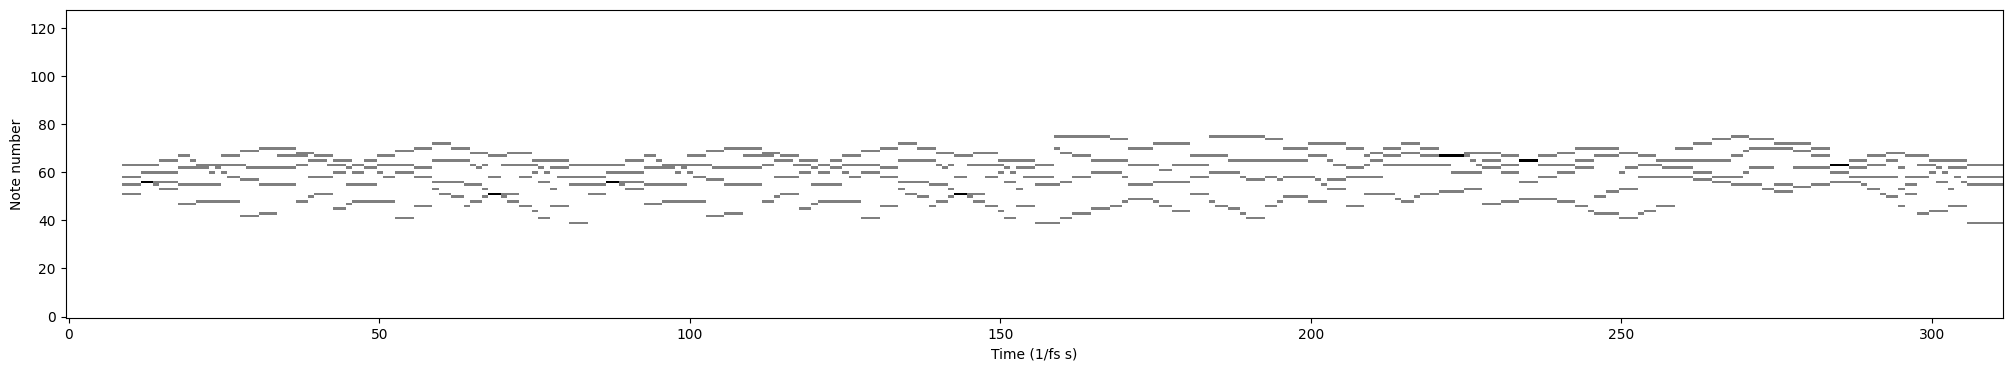

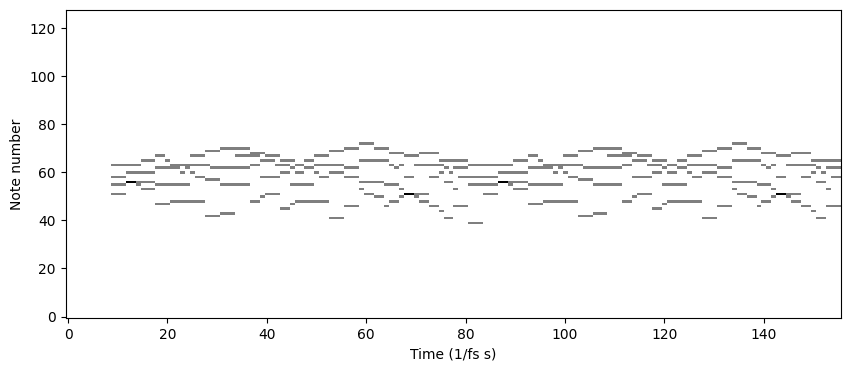

In [92]:
# Test function
sample_piano_roll = composers_df['piano_roll'].iloc[1]
max_length = int(sample_piano_roll.shape[1] * 0.5)

# Plot piano roll before padding/truncation
fig, ax = plt.subplots(figsize=(25, 4))
ax.imshow(
    sample_piano_roll,
    aspect='auto',
    origin='lower',
    interpolation='nearest',
    cmap='gray_r'
)
plt.xlabel('Time (1/fs s)')
plt.ylabel('Note number')
plt.show()

sample_padded_piano_roll = pad_piano_roll(sample_piano_roll, max_length)

# Plot piano roll after padding/truncation
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(
    sample_padded_piano_roll,
    aspect='auto',
    origin='lower',
    interpolation='nearest',
    cmap='gray_r'
)
plt.xlabel('Time (1/fs s)')
plt.ylabel('Note number')
plt.show()

In [93]:
# Since the length of the piano rolls has a lot of outliers, set the maximum
# sequence length for the  to be the 75th percentile
piano_roll_ts = composers_df['piano_roll'].apply(lambda x: x.T.shape[0]).values
max_length = int(np.percentile(piano_roll_ts, 50))

# Pad the piano rolls to be the same length
composers_df['piano_roll'] = composers_df['piano_roll'].apply(lambda roll: pad_piano_roll(roll, max_length))

# Transpose the piano rolls so they have the shape (time_steps, notes)
composers_df['piano_roll'] = composers_df['piano_roll'].apply(lambda roll: roll.T)

In [94]:
# Print new shape of the piano rolls
composers_df['piano_roll'].iloc[1].shape

(1013, 128)

### Preprocess note sequences

In [296]:
# Define a method that pads or truncates note sequences to be the same length
def pad_note_sequence(note_sequence, seq_length):
  # Define a new note sequence of the specified sequence length
  padded_note_sequence = np.zeros((seq_length, note_sequence.shape[1]), dtype=np.float32)

  # If the note sequence is shorter than the sequence length, add padding
  if note_sequence.shape[0] < seq_length:
    padded_note_sequence[:note_sequence.shape[0], :] = note_sequence[:, :]

  # If the note sequence is too long, truncate it
  elif note_sequence.shape[0] > seq_length:
    padded_note_sequence[:seq_length, :] = note_sequence[:seq_length, :]

  # Handle edge case where the note sequence is already the exact maximum length
  else:
    padded_note_sequence = note_sequence

  return padded_note_sequence

In [297]:
# Test the padding method
sample_note_sequence = composers_df['note_sequence'].iloc[0]
print(sample_note_sequence.shape)

max_length = 500
sample_note_sequence_padded = pad_note_sequence(sample_note_sequence, max_length)
print(sample_note_sequence_padded.shape)

max_length = 5000
sample_note_sequence_padded = pad_note_sequence(sample_note_sequence, max_length)
print(sample_note_sequence_padded.shape)

(318, 5)
(500, 5)
(5000, 5)


In [298]:
# Determine the maximum length for the note sequences
note_sequence_lengths = composers_df['note_sequence'].apply(lambda x: x.shape[0]).values
max_length = int(np.percentile(note_sequence_lengths, 75))

In [299]:
# Pad the note sequences to be the same length
composers_df['note_sequence'] = composers_df['note_sequence'].apply(lambda seq:
                                                                    pad_note_sequence(seq, max_length))

### Split the data

In [101]:
# Split the data into train and test sets
train_df, test_df = train_test_split(composers_df, test_size=0.2, random_state=42)

### Normalize non-sequential features

In [102]:
# Select the non-sequential song statistics features
non_sequential_features = [
    'num_instruments',
    'song_duration',
    'total_notes',
    'most_frequent_note',
    'most_frequent_instrument',
    'min_note',
    'max_note',
    'mean_velocity',
    'min_velocity',
    'max_velocity',
    'mean_duration',
    'min_duration',
    'max_duration',
]


In [103]:
# View the scale of each feature before transformation
composers_df[non_sequential_features].describe()

num_instruments  song_duration   total_notes  most_frequent_note  \
count      1236.000000    1236.000000   1236.000000         1236.000000   
mean          5.420712     296.976844   3789.482201           64.544498   
std           4.813883     328.642515   5410.143328            6.939213   
min           1.000000      17.500000     83.000000           38.000000   
25%           2.000000      64.568339    451.500000           60.000000   
50%           4.000000     204.728405   1638.500000           65.000000   
75%           6.000000     410.380066   5495.250000           69.000000   
max          40.000000    5032.305478  47745.000000           88.000000   

       most_frequent_instrument     min_note     max_note  mean_velocity  \
count               1236.000000  1236.000000  1236.000000    1236.000000   
mean                  13.037217    34.060680    85.849515      79.886450   
std                   21.437420     6.429842     7.464464      19.307415   
min                    0.000000    17.000000    66.000000      30.812865   
25%                    0.000000    29.000000    80.000000      64.000000   
50%                    0.000000    35.000000    86.000000      80.549333   
75%                   40.000000    38.000000    89.000000      96.000000   
max                   88.000000    55.000000   105.000000     127.000000   

       min_velocity  max_velocity  mean_duration  min_duration  max_duration  
count   1236.000000   1236.000000    1236.000000   1236.000000   1236.000000  
mean      56.276699    103.430421       0.415750      0.093617      6.196782  
std       35.190348     16.909787       0.218120      0.091813     17.796597  
min        1.000000     62.000000       0.098049      0.000417      0.277144  
25%       25.000000     96.000000       0.248513      0.033557      1.796875  
50%       49.000000    100.000000       0.353004      0.061433      3.202116  
75%       96.000000    120.000000       0.565650      0.150000      6.666666  
max      127.000000    127.000000       1.547299      0.750000    300.481875

In [104]:
# Initialize a StandardScaler
scaler = preprocessing.StandardScaler()

# Normalize the non-sequential features
train_df[non_sequential_features] = scaler.fit_transform(train_df[non_sequential_features])
test_df[non_sequential_features] = scaler.transform(test_df[non_sequential_features])

In [105]:
# View the shape of the non-sequential features
train_df[non_sequential_features].shape

(988, 13)

In [106]:
# Set the non-sequential training and test data
x_non_seq_train = train_df[non_sequential_features]
x_non_seq_test = test_df[non_sequential_features]

### Normalize the piano rolls

In [107]:
# Initialize a StandardScaler
scaler = preprocessing.StandardScaler()

# Fit the scaler on all the rows of the training set
scaler.fit(np.vstack(train_df['piano_roll'].values))

# Use the fitted StandardScaler to transform the training and test piano rolls
train_df['piano_roll'] = train_df['piano_roll'].apply(lambda roll: scaler.transform(roll))
test_df['piano_roll'] = test_df['piano_roll'].apply(lambda roll: scaler.transform(roll))


### Normalize the note sequences

In [379]:
# Initialize a StandardScaler
scaler = preprocessing.StandardScaler()

# Fit the scaler on all the rows of the training set
scaler.fit(np.vstack([notes[:, :-2] for notes in train_df['note_sequence']]))

# Use the fitted StandardScaler to transform the training and test note sequences
train_df['note_sequence'] = train_df['note_sequence'].apply(lambda notes: scaler.transform(notes[:,:-2]))
test_df['note_sequence'] = test_df['note_sequence'].apply(lambda notes: scaler.transform(notes[:,:-2]))

### Window the sequential data

In [112]:
# Define a function that breaks the data into windows for training and testing
def generate_windows(sequences, window_size, stride, piano_roll):
  all_windows = []
  all_labels = []

  # For every song and composer label, break the song into ovelapping windows
  for sequence, label in sequences:
    seq_windows = []
    num_windows = sequence.shape[0] // stride if piano_roll else len(sequence) // stride

    for i in range(num_windows):
      window_start = i * stride
      window_end = window_start + window_size

      # If the next window would not go over the end of the song, add it to the
      # set of windows for this song
      if window_end <= len(sequence):
        window = sequence[window_start:window_end]
        seq_windows.append(window)

    # Collect all the windows and label for every song
    all_windows.append(seq_windows)
    all_labels.append(label)

  return np.expand_dims(np.array(all_windows), axis=-1), np.array(all_labels)

In [113]:
# Generate piano roll windows for the training and test sets
if use_piano_rolls:

    # Set the window size and stride (stride determines how much the windows
    # overlap, smaller stride -> more overlap)
    window_size = 128
    stride = 64

    # Get all of the piano rolls and composer labels from the training set
    train_sequences = list(zip(train_df['piano_roll'], train_df['composer_encoded']))

    # Generate windows and labels for the training set
    train_windows, train_labels = generate_windows(train_sequences, window_size, stride, piano_roll=True)
    print(f"Sequential training data shape: {train_windows.shape}")

    # Get all of the piano rolls and composer labels from the test set
    test_sequences = list(zip(test_df['piano_roll'], test_df['composer_encoded']))

    # Generate windows and labels for the test set
    test_windows, test_labels = generate_windows(test_sequences, window_size, stride, piano_roll=True)
    print(f"Sequential test data shape: {test_windows.shape}")

# Geneare note sequence windows for the training and test sets
else:
    # Set the window size and stride
    window_size = 256
    stride = 128

    # Get all of the note sequences and composer labels from the training set
    train_sequences = list(zip(train_df['note_sequence'], train_df['composer_encoded']))

    # Generate windows and labels for the training set
    train_windows, train_labels = generate_windows(train_sequences, window_size, stride, piano_roll=False)
    print(f"Sequential training data shape: {train_windows.shape}")

    # Get all of the note sequences and composer labels from the test set
    test_sequences = list(zip(test_df['note_sequence'], test_df['composer_encoded']))

    # Generate windows and labels for the test set
    test_windows, test_labels = generate_windows(test_sequences, window_size, stride, piano_roll=False)
    print(f"Sequential test data shape: {test_windows.shape}")

# Set the training and test labels
y_train = train_labels
print(f"Training label shape: {y_train.shape}")

y_test = test_labels
print(f"Test label shape: {y_test.shape}")

Sequential training data shape: (988, 14, 128, 128, 1)
Sequential test data shape: (248, 14, 128, 128, 1)
Training label shape: (988,)
Test label shape: (248,)


## Model Building, Training, Evaluation, and Optimization


### CNN-LSTM: Piano roll model before optimization

In [114]:
# Define the sequential and non-sequential input layers for the model
seq_input = layers.Input(shape=train_windows.shape[1:])
non_seq_input = layers.Input(shape=(x_non_seq_train.shape[1],))

# Pass the piano roll windows through a CNN to extract spatial features
# The TimeDistributed wrapper will apply the CNN to every window for a song
x = layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu', padding='same'))(seq_input)
x = layers.TimeDistributed(layers.MaxPooling2D(padding='same'))(x)
x = layers.TimeDistributed(layers.Flatten())(x)

# Extract temporal features from the output of the CNN layer
x = layers.LSTM(16)(x)

# Extract features from the non-sequential input
y = layers.Dense(32, activation='relu')(non_seq_input)

# Combine the sequential and non-sequential output
combined = layers.Concatenate()([x, y])

# Run the combined output through 2 fully connected layers
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(32, activation='relu')(z)

# Classification layer
output = layers.Dense(units = 4, activation ='softmax')(z)

In [115]:
# Instantiate the model and summarize the architecture
pianoroll_model = Model(inputs=[seq_input, non_seq_input], outputs=output)
pianoroll_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 14, 128, 128,   │              0 │ -                      │
│                           │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed          │ (None, 14, 128, 128,   │            320 │ input_layer[0][0]      │
│ (TimeDistributed)         │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_1        │ (None, 14, 64, 64, 32) │              0 │ time_distributed[0][0] │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_2        │ (None, 14, 131072)     │              0 │ time_distributed_1[0]… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ (None, 16)             │      8,389,696 │ time_distributed_2[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 32)             │            448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 48)             │              0 │ lstm[0][0],            │
│                           │                        │                │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 64)             │          3,136 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 32)             │          2,080 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 4)              │            132 │ dense_2[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,395,812 (32.03 MB)

 Trainable params: 8,395,812 (32.03 MB)

 Non-trainable params: 0 (0.00 B)

In [116]:
# Compile the model
pianoroll_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

In [117]:
# Train the model
history = pianoroll_model.fit(
  x=[train_windows, x_non_seq_train],
  y=y_train,
  validation_data=([test_windows, x_non_seq_test], y_test),
  epochs=20
)

Epoch 1/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 120ms/step - accuracy: 0.4448 - loss: 1.2675 - val_accuracy: 0.6855 - val_loss: 0.8668
Epoch 2/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.7257 - loss: 0.7873 - val_accuracy: 0.7097 - val_loss: 0.7248
Epoch 3/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.7744 - loss: 0.6292 - val_accuracy: 0.7621 - val_loss: 0.6240
Epoch 4/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8598 - loss: 0.4816 - val_accuracy: 0.7863 - val_loss: 0.5678
Epoch 5/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.8797 - loss: 0.3548 - val_accuracy: 0.8185 - val_loss: 0.4695
Epoch 6/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9014 - loss: 0.2993 - val_accuracy: 0.8024 - val_loss: 0.4273
Epoch 7/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9118 - loss: 0.2624 - val_accuracy: 0.8347 - val_loss: 0.4245
Epoch 8/20
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 89ms/step - accuracy: 0.9322 - loss: 0.2178 - val_accuracy: 0.8548 - 

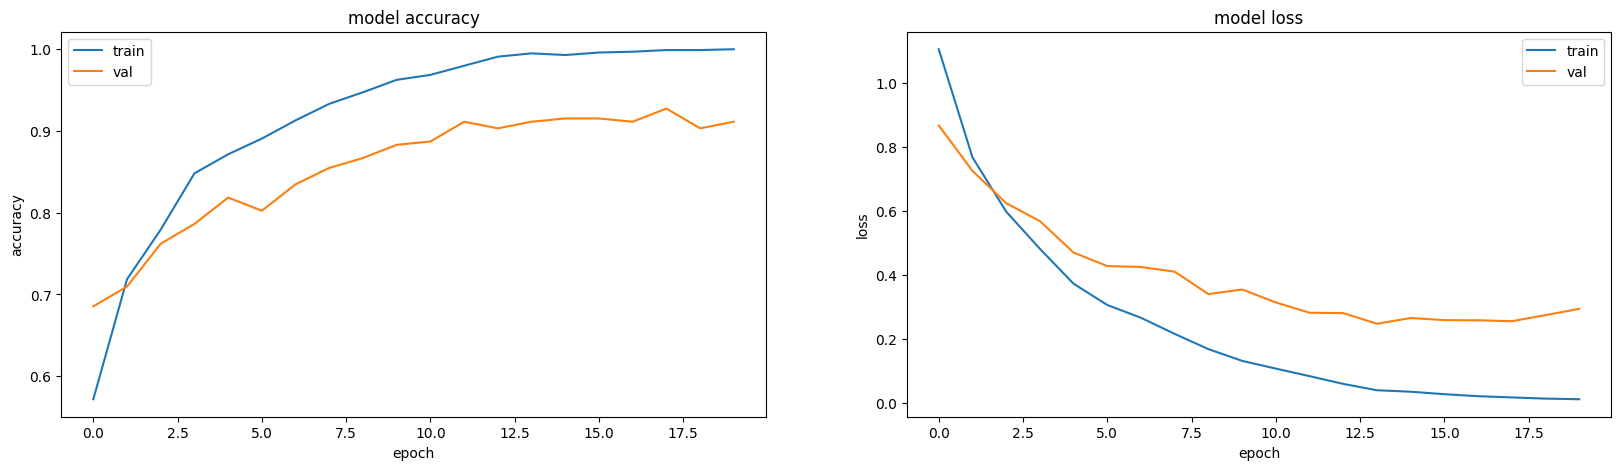

In [118]:
# Plot learning curves for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'])
plt.show()

In [119]:
# Evaluate the model on the test set
test_loss, test_acc = pianoroll_model.evaluate([test_windows, x_non_seq_test], y_test)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9021 - loss: 0.3553
Test Loss: 0.2937
Test Accuracy: 0.9113


In [120]:
# Generate predicted probabilities for the test set
y_pred = pianoroll_model.predict([test_windows, x_non_seq_test])

# Get the predicted label for each set of probabilities
predictions = np.argmax(y_pred, axis=1)

# Get the true labels from the test set
targets = y_test

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step


              precision    recall  f1-score   support

           0       0.94      0.94      0.94       110
           1       0.85      0.92      0.88        49
           2       0.93      0.87      0.90        31
           3       0.89      0.88      0.89        58

    accuracy                           0.91       248
   macro avg       0.90      0.90      0.90       248
weighted avg       0.91      0.91      0.91       248



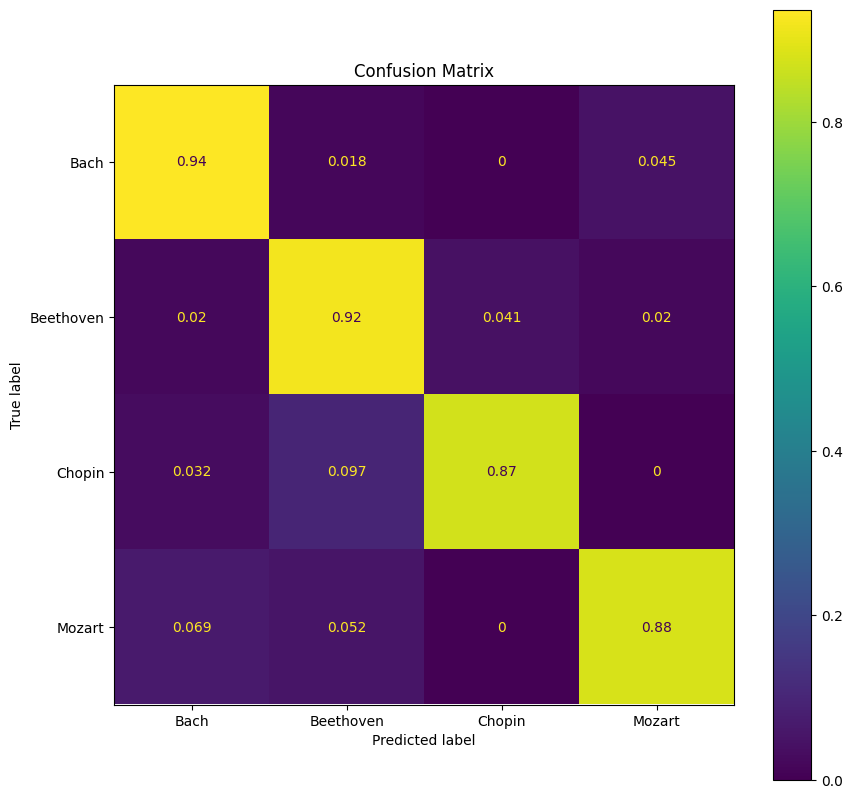

In [121]:
# Generate a classification report (precision, recall, f1-score)
report = classification_report(targets, predictions)
print(report)

# Create and display confusion matrix
cm = confusion_matrix(targets, predictions, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
cm_display.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()

### CNN-LSTM: Piano roll model after optimization (Best)

In [138]:
# Define the sequential and non-sequential input layers for the model
seq_input = layers.Input(shape=train_windows.shape[1:])
non_seq_input = layers.Input(shape=(x_non_seq_train.shape[1],))

# Pass the piano roll windows through a CNN to extract spatial features
# The TimeDistributed wrapper will apply the CNN to every window for a song
x = layers.TimeDistributed(layers.Conv2D(32, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=0.0001)))(seq_input)
x = layers.TimeDistributed(layers.MaxPooling2D(padding='same'))(x)
x = layers.TimeDistributed(layers.Flatten())(x)

# Extract temporal features from the output of the CNN layer
x = layers.LSTM(16)(x)

# Extract features from the non-sequential input
y = layers.Dense(64, activation='relu')(non_seq_input)

# Combine the sequential and non-sequential output
combined = layers.Concatenate()([x, y])

# Run the combined output through 2 fully connected layers
z = layers.Dense(128, activation='relu')(combined)
z = layers.Dense(32, activation='relu')(z)

# Classification model
output = layers.Dense(units = 4, activation ='softmax')(z)

In [139]:
# Instantiate and summarize the model
pianoroll_model = Model(inputs=[seq_input, non_seq_input], outputs=output)
pianoroll_model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 14, 128, 128,   │              0 │ -                      │
│ (InputLayer)              │ 1)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_9        │ (None, 14, 128, 128,   │            320 │ input_layer_6[0][0]    │
│ (TimeDistributed)         │ 32)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_10       │ (None, 14, 64, 64, 32) │              0 │ time_distributed_9[0]… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_11       │ (None, 14, 131072)     │              0 │ time_distributed_10[0… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_7             │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ (None, 16)             │      8,389,696 │ time_distributed_11[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 64)             │            896 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_3             │ (None, 80)             │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 128)            │         10,368 │ concatenate_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_14 (Dense)          │ (None, 32)             │          4,128 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_15 (Dense)          │ (None, 4)              │            132 │ dense_14[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,405,540 (32.06 MB)

 Trainable params: 8,405,540 (32.06 MB)

 Non-trainable params: 0 (0.00 B)

In [140]:
# Compile the model
pianoroll_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

In [141]:
# Create an early stopping callback to stop training the model once loss plataues
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=6,
    restore_best_weights=True,
    verbose=True
)

# Create a callback to reduce the learning rate by a factor of 0.1 if validation
# accuracy does not approve for more than the specified number of epochs
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=4,
    min_delta=0.01
)

# Train the model
history = pianoroll_model.fit(
  x=[train_windows, x_non_seq_train],
  y=y_train,
  validation_data=([test_windows, x_non_seq_test], y_test),
  batch_size=8,
  epochs=30,
  callbacks=[es_callback, lr_callback]
)

Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 7s 33ms/step - accuracy: 0.6399 - loss: 0.9620 - val_accuracy: 0.7258 - val_loss: 0.6906 - learning_rate: 0.0010
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7670 - loss: 0.5816 - val_accuracy: 0.7339 - val_loss: 0.6045 - learning_rate: 0.0010
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.8154 - loss: 0.4423 - val_accuracy: 0.7702 - val_loss: 0.4777 - learning_rate: 0.0010
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8494 - loss: 0.3956 - val_accuracy: 0.7863 - val_loss: 0.4600 - learning_rate: 0.0010
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8670 - loss: 0.3227 - val_accuracy: 0.8105 - val_loss: 0.4461 - learning_rate: 0.0010
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.8880 - loss: 0.3085 - val_accuracy: 0.8387 - val_loss: 0.3929 - learning_rate: 0.0010
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.9017 - loss: 0.

In [146]:
# Plot learning curves for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'])
plt.show()

In [143]:
# Evaluate the model on the test set
test_loss, test_acc = pianoroll_model.evaluate([test_windows, x_non_seq_test], y_test)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.9372 - loss: 0.3396
Test Loss: 0.2333
Test Accuracy: 0.9516


In [144]:
# Generate predicted probabilities for the test set
y_pred = pianoroll_model.predict([test_windows, x_non_seq_test])

# Get the predicted label for each set of probabilities
predictions = np.argmax(y_pred, axis=1)

# Get the true labels from the test set
targets = y_test

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step


              precision    recall  f1-score   support

           0       0.97      0.95      0.96       110
           1       0.92      0.98      0.95        49
           2       0.97      1.00      0.98        31
           3       0.93      0.91      0.92        58

    accuracy                           0.95       248
   macro avg       0.95      0.96      0.95       248
weighted avg       0.95      0.95      0.95       248



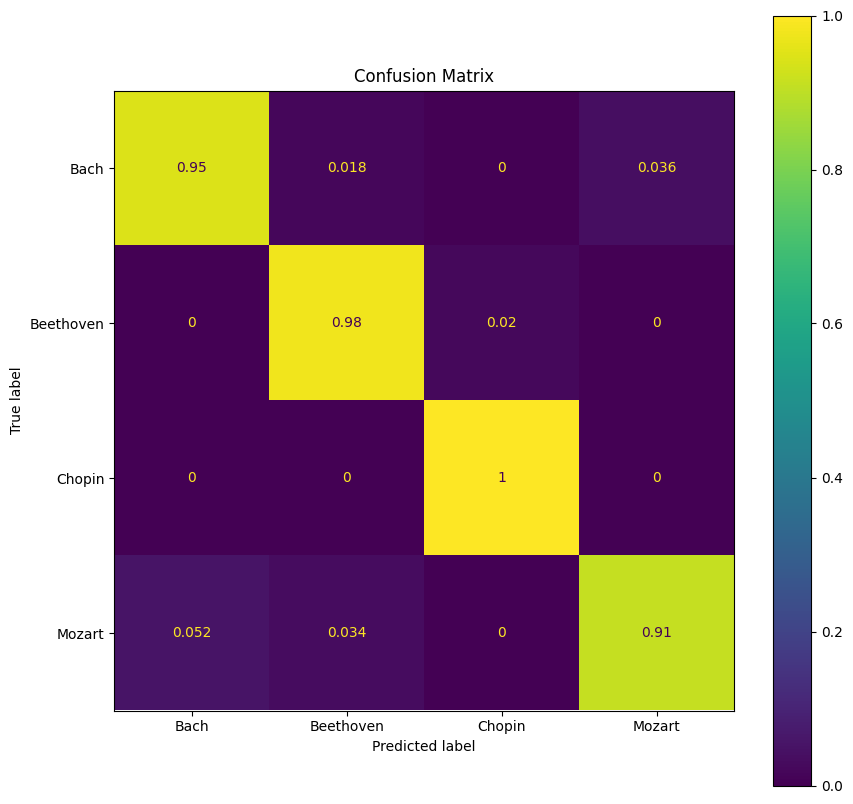

In [145]:
# Generate a classification report (precision, recall, f1-score)
report = classification_report(targets, predictions)
print(report)

# Create and display confusion matrix
cm = confusion_matrix(targets, predictions, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
cm_display.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()

### CNN-LSTM: Note sequences model before optimization

In [384]:
# Define the sequential and non-sequential input layers for the model
seq_input = layers.Input(shape=train_windows.shape[1:])
non_seq_input = layers.Input(shape=(x_non_seq_train.shape[1],))

# Pass the piano roll windows through a TimeDistributedCNN to extract spatial features
x = layers.TimeDistributed(layers.Conv2D(32, 2, activation='relu', padding='same'))(seq_input)
x = layers.TimeDistributed(layers.MaxPooling2D(padding='same'))(x)
x = layers.TimeDistributed(layers.Flatten())(x)

# Extract temporal features from the output of the CNN layer
x = layers.LSTM(32)(x)

# Extract features from the non-sequential input
y = layers.Dense(32, activation='relu')(non_seq_input)
y = layers.Dense(32, activation='relu')(y)

# Combine sequential and non-sequential output
combined = layers.Concatenate()([x, y])

# Run the combined layer through a fully connected layer
z = layers.Dense(128, activation='relu')(combined)

# Classification layer
output = layers.Dense(units = 4, activation ='softmax')(z)

In [385]:
# Initialize the model and summarize
notesequence_model = Model(inputs=[seq_input, non_seq_input], outputs=output)
notesequence_model.summary()

Model: "functional_45"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_90            │ (None, 41, 256, 3, 1)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_156      │ (None, 41, 256, 3, 32) │            160 │ input_layer_90[0][0]   │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_157      │ (None, 41, 128, 2, 32) │              0 │ time_distributed_156[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_91            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_158      │ (None, 41, 8192)       │              0 │ time_distributed_157[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_202 (Dense)         │ (None, 32)             │            448 │ input_layer_91[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_44 (LSTM)            │ (None, 32)             │      1,052,800 │ time_distributed_158[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_203 (Dense)         │ (None, 32)             │          1,056 │ dense_202[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_44            │ (None, 64)             │              0 │ lstm_44[0][0],         │
│ (Concatenate)             │                        │                │ dense_203[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_204 (Dense)         │ (None, 128)            │          8,320 │ concatenate_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_205 (Dense)         │ (None, 4)              │            516 │ dense_204[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,063,300 (4.06 MB)

 Trainable params: 1,063,300 (4.06 MB)

 Non-trainable params: 0 (0.00 B)

In [386]:
# Compile the model
notesequence_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

In [387]:
# Create an early stopping callback to stop training the model once loss plataues
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=True
)

# Create a callback to reduce the learning rate by a factor of 0.1 if validation
# accuracy does not approve for more than 5 epochs
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_delta=0.05
)

# Train the model
history = notesequence_model.fit(
  x=[train_windows, x_non_seq_train],
  y=y_train,
  validation_data=([test_windows, x_non_seq_test], y_test),
  batch_size=32,
  epochs=30,
  callbacks=[es_callback, lr_callback]
)

Epoch 1/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.5021 - loss: 1.1487 - val_accuracy: 0.6976 - val_loss: 0.8567 - learning_rate: 0.0010
Epoch 2/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.6706 - loss: 0.8381 - val_accuracy: 0.7258 - val_loss: 0.6950 - learning_rate: 0.0010
Epoch 3/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7475 - loss: 0.6550 - val_accuracy: 0.7460 - val_loss: 0.6392 - learning_rate: 0.0010
Epoch 4/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.7513 - loss: 0.6035 - val_accuracy: 0.7702 - val_loss: 0.5911 - learning_rate: 0.0010
Epoch 5/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.7957 - loss: 0.5191 - val_accuracy: 0.7823 - val_loss: 0.5605 - learning_rate: 0.0010
Epoch 6/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - accuracy: 0.8192 - loss: 0.4653 - val_accuracy: 0.7782 - val_loss: 0.5126 - learning_rate: 0.0010
Epoch 7/30
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.8123 - loss: 0.4526 - val_ac

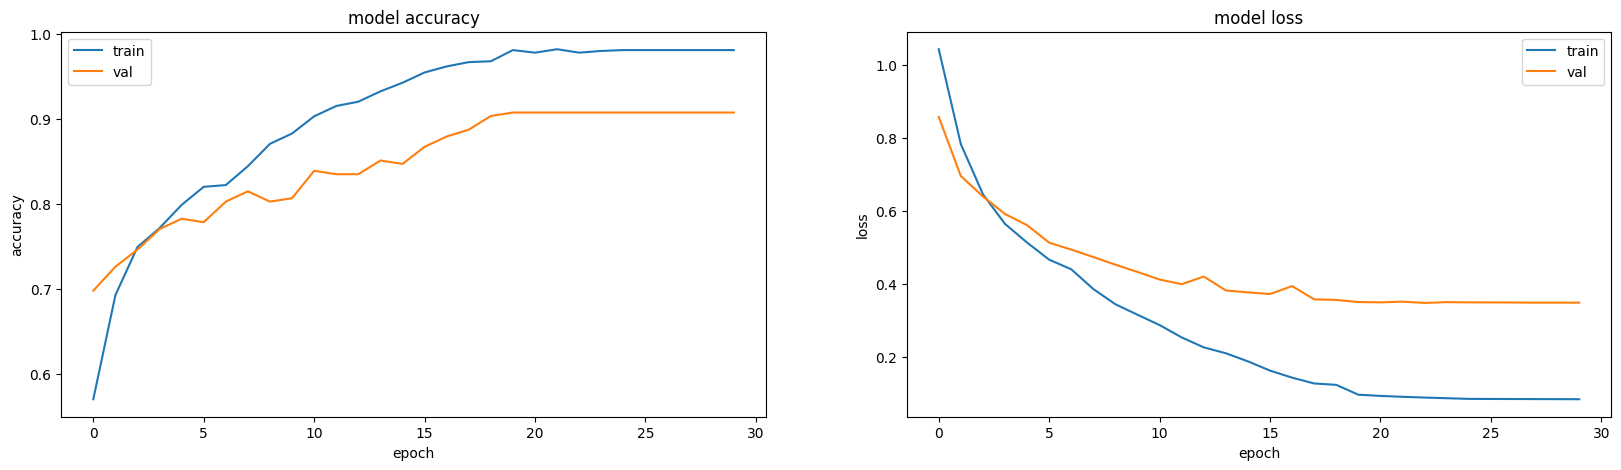

In [388]:
# Plot learning curves for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'])
plt.show()

In [389]:
# Evaluate the model on the test set
test_loss, test_acc = notesequence_model.evaluate([test_windows, x_non_seq_test], y_test)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8738 - loss: 0.4494
Test Loss: 0.3477
Test Accuracy: 0.9073


In [390]:
# Generate predicted probabilities for the test set
y_pred = notesequence_model.predict([test_windows, x_non_seq_test])

# Get the predicted label for each set of probabilities
predictions = np.argmax(y_pred, axis=1)

# Get the true labels from the test set
targets = y_test

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 144ms/step


              precision    recall  f1-score   support

           0       0.98      0.93      0.95       110
           1       0.89      0.86      0.88        49
           2       0.81      0.97      0.88        31
           3       0.85      0.88      0.86        58

    accuracy                           0.91       248
   macro avg       0.88      0.91      0.89       248
weighted avg       0.91      0.91      0.91       248



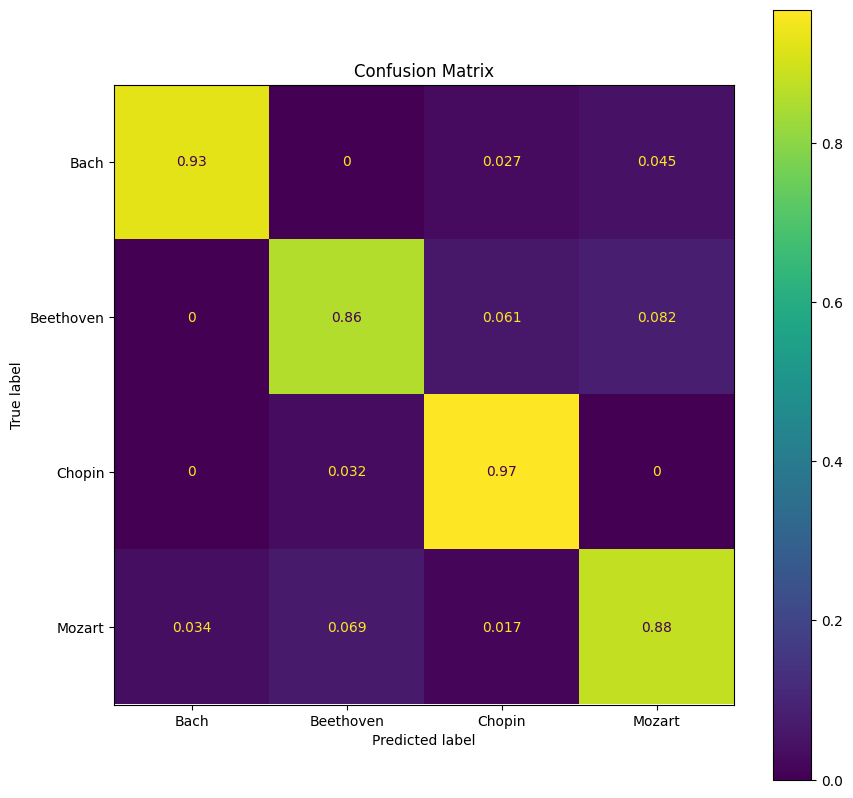

In [392]:
# Generate a classification report
report = classification_report(targets, predictions)
print(report)

# Create and display confusion matrix
cm = confusion_matrix(targets, predictions, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
cm_display.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()

### CNN-LSTM: Note sequence model after optimization

In [647]:
# Define sequential and non-sequential input layers
seq_input = layers.Input(shape=train_windows.shape[1:])
non_seq_input = layers.Input(shape=(x_non_seq_train.shape[1],))

# Extract spatial features using a TimeDistributed CNN
x = layers.TimeDistributed(layers.Conv2D(16, 3, activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.L2(l2=0.001)))(seq_input)
x = layers.TimeDistributed(layers.Dropout(0.4))(x)
x = layers.TimeDistributed(layers.MaxPooling2D(padding='same'))(x)
x = layers.TimeDistributed(layers.Flatten())(x)

# Extract temporal feautres using an LSTM
x = layers.LSTM(16)(x)

# Extract features from the non-sequential input
y = layers.Dense(64, activation='relu')(non_seq_input)
y = layers.Dense(32, activation='relu')(y)
y = layers.Dense(8, activation='relu')(y)

# Combine sequential and non-sequential output
combined = layers.Concatenate()([x, y])

#
z = layers.Dense(64, activation='relu')(combined)
z = layers.Dense(64, activation='relu')(z)
output = layers.Dense(units = 4, activation ='softmax')(z)

In [648]:
# Instantiate and summarize model
notesequence_model = Model(inputs=[seq_input, non_seq_input], outputs=output)
notesequence_model.summary()

Model: "functional_78"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_156           │ (None, 41, 256, 3, 1)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_288      │ (None, 41, 256, 3, 16) │            160 │ input_layer_156[0][0]  │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_289      │ (None, 41, 256, 3, 16) │              0 │ time_distributed_288[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_157           │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_290      │ (None, 41, 128, 2, 16) │              0 │ time_distributed_289[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_382 (Dense)         │ (None, 64)             │            896 │ input_layer_157[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ time_distributed_291      │ (None, 41, 4096)       │              0 │ time_distributed_290[… │
│ (TimeDistributed)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_383 (Dense)         │ (None, 32)             │          2,080 │ dense_382[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_77 (LSTM)            │ (None, 16)             │        263,232 │ time_distributed_291[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_384 (Dense)         │ (None, 8)              │            264 │ dense_383[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_77            │ (None, 24)             │              0 │ lstm_77[0][0],         │
│ (Concatenate)             │                        │                │ dense_384[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_385 (Dense)         │ (None, 64)             │          1,600 │ concatenate_77[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_386 (Dense)         │ (None, 64)             │          4,160 │ dense_385[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_387 (Dense)         │ (None, 4)              │            260 │ dense_386[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 272,652 (1.04 MB)

 Trainable params: 272,652 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [649]:
# Compile the model
notesequence_model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy']
)

In [650]:
# Create an early stopping callback to stop training the model once loss plataues
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=8,
    restore_best_weights=True,
    verbose=True
)

# Create a callback to reduce the learning rate by a factor of 0.1 if validation
# accuracy does not approve for more than specified number of epochs
lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.1,
    patience=6,
    min_delta=0.05
)

# Train the model
history = notesequence_model.fit(
  x=[train_windows, x_non_seq_train],
  y=y_train,
  validation_data=([test_windows, x_non_seq_test], y_test),
  batch_size=8,
  epochs=30,
  callbacks=[es_callback, lr_callback]
)

Epoch 1/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 14s 32ms/step - accuracy: 0.5162 - loss: 1.1293 - val_accuracy: 0.7298 - val_loss: 0.7264 - learning_rate: 0.0010
Epoch 2/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7130 - loss: 0.6735 - val_accuracy: 0.7419 - val_loss: 0.5930 - learning_rate: 0.0010
Epoch 3/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7767 - loss: 0.5528 - val_accuracy: 0.7863 - val_loss: 0.4567 - learning_rate: 0.0010
Epoch 4/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8231 - loss: 0.4371 - val_accuracy: 0.8347 - val_loss: 0.4506 - learning_rate: 0.0010
Epoch 5/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8541 - loss: 0.3695 - val_accuracy: 0.8145 - val_loss: 0.4945 - learning_rate: 0.0010
Epoch 6/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8463 - loss: 0.3539 - val_accuracy: 0.8105 - val_loss: 0.4746 - learning_rate: 0.0010
Epoch 7/30
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.8709 - loss: 0

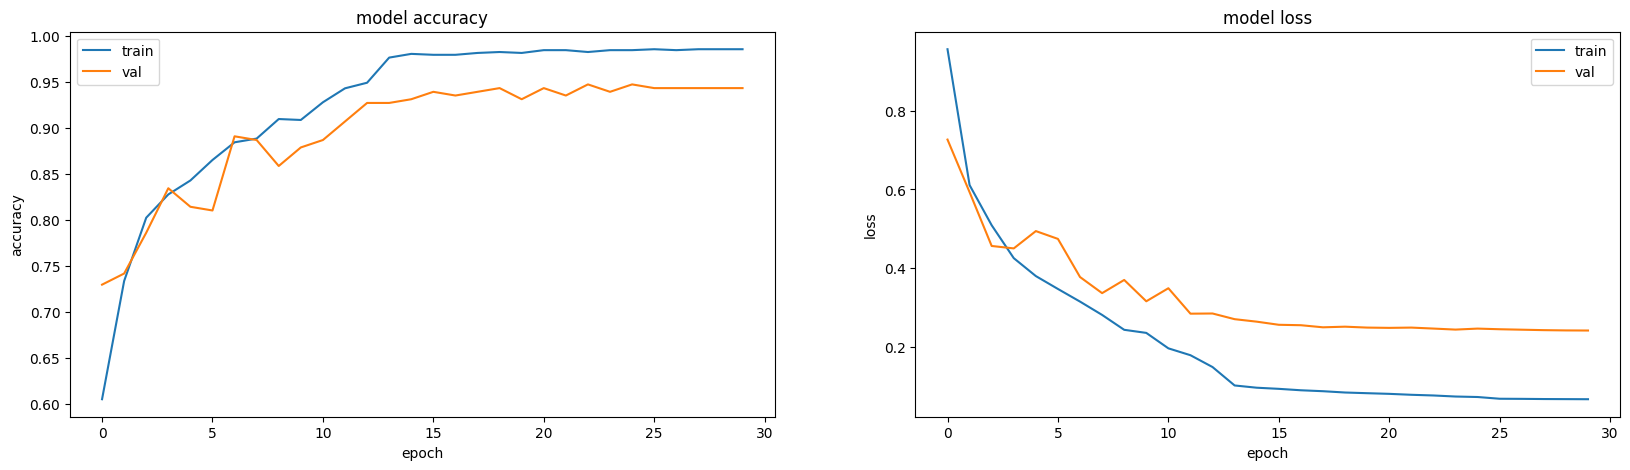

In [651]:
# Plot learning curves for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20,5))
ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('model accuracy')
ax[0].set_ylabel('accuracy')
ax[0].set_xlabel('epoch')
ax[0].legend(['train', 'val'])

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('model loss')
ax[1].set_ylabel('loss')
ax[1].set_xlabel('epoch')
ax[1].legend(['train', 'val'])
plt.show()

In [652]:
# Evaluate the model on the test set
test_loss, test_acc = notesequence_model.evaluate([test_windows, x_non_seq_test], y_test)
print('Test Loss: {:.4f}'.format(test_loss))
print('Test Accuracy: {:.4f}'.format(test_acc))

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9358 - loss: 0.3019
Test Loss: 0.2474
Test Accuracy: 0.9476


In [653]:
# Generate predicted probabilities for the test set
y_pred = notesequence_model.predict([test_windows, x_non_seq_test])

# Get the predicted label for each set of probabilities
predictions = np.argmax(y_pred, axis=1)

# Get the true labels from the test set
targets = y_test

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 164ms/step


              precision    recall  f1-score   support

           0       0.96      0.95      0.96       110
           1       0.94      0.98      0.96        49
           2       0.91      0.94      0.92        31
           3       0.95      0.91      0.93        58

    accuracy                           0.95       248
   macro avg       0.94      0.95      0.94       248
weighted avg       0.95      0.95      0.95       248



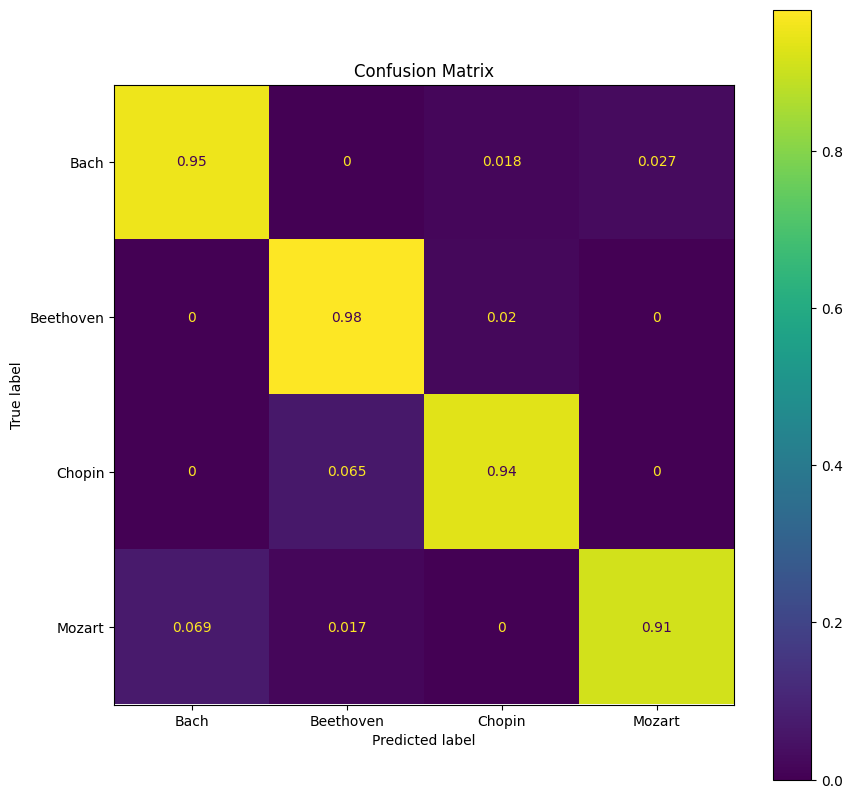

In [654]:
# Generate classification report
report = classification_report(targets, predictions)
print(report)

# Create and display confusion matrix
cm = confusion_matrix(targets, predictions, normalize='true')
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
fig, ax = plt.subplots(figsize=(10, 10))
cm_display.plot(ax=ax)
plt.title('Confusion Matrix')
plt.show()